<a href="https://colab.research.google.com/github/tekluw/tekluw/blob/main/July_16_2025_HIV_Incidence_Prediction_Final_Note_book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Data Cleaning and Parsing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats.mstats import winsorize


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
# mountingunziping datasourc from Google drive
!unzip "/content/drive/MyDrive/Colab Notebooks/hiv_zip.zip" -d "/content/extracted_folder/"

Archive:  /content/drive/MyDrive/Colab Notebooks/hiv_zip.zip
  inflating: /content/extracted_folder/hiv_zip/aa_hiv_data_final_2025.csv  
  inflating: /content/extracted_folder/hiv_zip/indicator_config.csv  


In [ ]:
df = pd.read_csv("/content/extracted_folder/hiv_zip/aa_hiv_data_final_2025.csv")

In [ ]:
# Clean column names
df.columns = df.columns.str.strip()

In [ ]:
df.head(5)

,periodid,periodname,periodcode,categoryoptioncomboid,categoryoptioncomboname,Clinics -2017_HIV_Clients receiving HIV test results (at PITC),Clinics HIV_Clients receiving HIV test results (at PITC),Clinics -2017_HIV_Clients receiving HIV test results (at VCT),Clinics HIV_Clients receiving HIV test results (at VCT),Clinics -2017_HIV_Clients testing positive for HIV (at PITC),...,Total_Tested_HealthCenters_PITC,Total_Positive_HealthCenters_PITC,Total_Tested_HealthCenters_VCT,Total_Positive_HealthCenters_VCT,Total_Tested_Hospitals_PITC,Total_Positive_Hospitals_PITC,Total_Tested_Hospitals_VCT,Total_Positive_Hospitals_VCT,AgeBand,Sex
0,201005,Tir 2010,201005,NCsDfLwsJbD,"< 1 year, Male",2.0,NaN,0.0,NaN,0.0,...,12.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,< 1 year,Male
1,201005,Tir 2010,201005,Zv06s01IYEp,"< 1 year, Female",1.0,NaN,0.0,NaN,0.0,...,10.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,< 1 year,Female
2,201005,Tir 2010,201005,VCjiUvR8LRp,"1 - 4 years, Male",7.0,NaN,0.0,NaN,0.0,...,329.0,1.0,9.0,0.0,212.0,1.0,0.0,0.0,1 - 4 years,Male
3,201005,Tir 2010,201005,uQGKsfDfdos,"1 - 4 years, Female",7.0,NaN,1.0,NaN,0.0,...,371.0,2.0,22.0,0.0,147.0,1.0,0.0,0.0,1 - 4 years,Female
4,201005,Tir 2010,201005,EZGJBfAul47,"5 - 9 Years, Male",16.0,NaN,1.0,NaN,0.0,...,80.0,2.0,14.0,0.0,156.0,3.0,0.0,0.0,5 - 9 Years,Male


In [ ]:
# Clean column names
df.columns = df.columns.str.strip()
print(df.columns)


Index(['periodid', 'periodname', 'periodcode', 'categoryoptioncomboid',
       'categoryoptioncomboname',
       'Clinics -2017_HIV_Clients receiving HIV test results (at PITC)',
       'Clinics HIV_Clients receiving HIV test results (at PITC)',
       'Clinics -2017_HIV_Clients receiving HIV test results (at VCT)',
       'Clinics HIV_Clients receiving HIV test results (at VCT)',
       'Clinics -2017_HIV_Clients testing positive for HIV (at PITC)',
       'Clinics HIV_Clients testing positive for HIV (at PITC)',
       'Clinics -2017_HIV_Clients testing positive for HIV (at VCT)',
       'Clinics HIV_Clients testing positive for HIV (at VCT)',
       'Health Centers -2017_HIV_Clients receiving HIV test results (at PITC)',
       'Health Centers HIV_Clients receiving HIV test results (at PITC)',
       'Health Centers -2017_HIV_Clients receiving HIV test results (at VCT)',
       'Health Centers HIV_Clients receiving HIV test results (at VCT)',
       'Health Centers -2017_HIV_Clients

In [ ]:
# dynamically generate total columns
def generate_totals_from_config(df, config_df):
    """
    Dynamically creates total columns in the DataFrame based on config info.
    Returns a modified copy of the DataFrame with added columns.

    Parameters:
    - df: main data table (e.g., your wide HIV dataset)
    - config_df: the configuration table with columns:
        'Modality', 'Facility_Type', 'Outcome', 'Column_Name'
    """
    df = df.copy()
    # Identify unique groupings
    grouping_keys = config_df[['Facility_Type', 'Modality', 'Outcome']].drop_duplicates()

    for _, row in grouping_keys.iterrows():
        facility = row['Facility_Type']
        modality = row['Modality']
        outcome = row['Outcome']

        # Create a clean column label
        col_label = f"Total_{outcome}_{facility.replace(' ', '')}_{modality}"

        # Find matching columns in config
        match_cols = config_df.loc[
            (config_df['Facility_Type'] == facility) &
            (config_df['Modality'] == modality) &
            (config_df['Outcome'] == outcome),
            'Column_Name'
        ].tolist()

        if match_cols:  # Ensure there are columns to sum
            # Ensure columns exist in df before summing
            existing_cols = [col for col in match_cols if col in df.columns]
            if existing_cols:
                # Fill NaN values with 0 for summation
                df[col_label] = df[existing_cols].fillna(0).sum(axis=1)
            else:
                df[col_label] = 0  # Default to zero if no matching columns in df
        else:
            df[col_label] = 0  # Default to zero if no matching columns in config

    return df # Added return statement

In [ ]:
def add_total_columns(df, config_df):
    # Identify unique groupings
    grouping_keys = config_df[['Facility_Type', 'Modality', 'Outcome']].drop_duplicates()

    for _, row in grouping_keys.iterrows():
        facility = row['Facility_Type']
        modality = row['Modality']
        outcome = row['Outcome']

        # Create a clean column label
        col_label = f"Total_{outcome}_{facility.replace(' ', '')}_{modality}"

        # Find matching columns in config
        match_cols = config_df.loc[
            (config_df['Facility_Type'] == facility) &
            (config_df['Modality'] == modality) &
            (config_df['Outcome'] == outcome),
            'Column_Name'
        ].tolist()

        if match_cols:  # Ensure there are columns to sum
            df[col_label] = df[match_cols].sum(axis=1)
        else:
            df[col_label] = 0  # Default to zero if no matching columns

    return df

In [ ]:
# Load raw data and config
import pandas as pd
import numpy as np

# load csv file into df
df = pd.read_csv("/content/extracted_folder/hiv_zip/aa_hiv_data_final_2025.csv")
cfg = pd.read_csv("/content/extracted_folder/hiv_zip/indicator_config.csv")

# Apply the dynamic total generator
df_with_totals = generate_totals_from_config(df, cfg)

# Add AgeBand and Sex columns to df_with_totals
if 'categoryoptioncomboname' in df_with_totals.columns:
    # Remove extra spaces and split into AgeBand and Sex
    df_with_totals['categoryoptioncomboname'] = df_with_totals['categoryoptioncomboname'].str.strip()
    split_cols = df_with_totals['categoryoptioncomboname'].str.split(',', expand=True)

    # Assign only if there are at least 2 parts
    if split_cols.shape[1] >= 2:
        df_with_totals['AgeBand'] = split_cols[0].str.strip()
        df_with_totals['Sex'] = split_cols[1].str.strip()
    else:
        df_with_totals['AgeBand'] = np.nan
        df_with_totals['Sex'] = np.nan

In [ ]:
import pandas as pd

config_data = [
    ['PITC', 'Clinics', 'Tested',  'Clinics -2017_HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Clinics', 'Tested',  'Clinics HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Clinics', 'Positive','Clinics -2017_HIV_Clients testing positive for HIV (at PITC)'],
    ['PITC', 'Clinics', 'Positive','Clinics HIV_Clients testing positive for HIV (at PITC)'],

    ['VCT',  'Clinics', 'Tested',  'Clinics -2017_HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Clinics', 'Tested',  'Clinics HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Clinics', 'Positive','Clinics -2017_HIV_Clients testing positive for HIV (at VCT)'],
    ['VCT',  'Clinics', 'Positive','Clinics HIV_Clients testing positive for HIV (at VCT)'],

    ['PITC', 'Health Centers', 'Tested',  'Health Centers -2017_HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Health Centers', 'Tested',  'Health Centers HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Health Centers', 'Positive','Health Centers -2017_HIV_Clients testing positive for HIV (at PITC)'],
    ['PITC', 'Health Centers', 'Positive','Health Centers HIV_Clients testing positive for HIV (at PITC)'],

    ['VCT',  'Health Centers', 'Tested',  'Health Centers -2017_HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Health Centers', 'Tested',  'Health Centers HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Health Centers', 'Positive','Health Centers -2017_HIV_Clients testing positive for HIV (at VCT)'],
    ['VCT',  'Health Centers', 'Positive','Health Centers HIV_Clients testing positive for HIV (at VCT)'],

    ['PITC', 'Hospitals', 'Tested',  'Hospitals -2017_HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Hospitals', 'Tested',  'Hospitals HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Hospitals', 'Positive','Hospitals -2017_HIV_Clients testing positive for HIV (at PITC)'],
    ['PITC', 'Hospitals', 'Positive','Hospitals HIV_Clients testing positive for HIV (at PITC)'],

    ['VCT',  'Hospitals', 'Tested',  'Hospitals -2017_HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Hospitals', 'Tested',  'Hospitals HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Hospitals', 'Positive','Hospitals -2017_HIV_Clients testing positive for HIV (at VCT)'],
    ['VCT',  'Hospitals', 'Positive','Hospitals HIV_Clients testing positive for HIV (at VCT)'],
]

config_df = pd.DataFrame(config_data, columns=['Modality', 'Facility_Type', 'Outcome', 'Column_Name'])

In [ ]:
df_with_totals.to_excel(r"T:\project_hiv\hiv_data_with_totals99.xlsx", index=False)

In [ ]:
# Save config_df to a location accessible in Colab
config_df.to_csv("/content/indicator_config.csv", index=False)

In [ ]:
df_with_totals.to_csv("/content/hiv_data_with_totals777.csv", index=False)

In [ ]:
#download table with totals
from google.colab import files
files.download("/content/hiv_data_with_totals777.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#view top 5 cells
import pandas as pd
pd.read_csv("/content/hiv_data_with_totals777.csv").head()

,periodid,periodname,periodcode,categoryoptioncomboid,categoryoptioncomboname,Clinics -2017_HIV_Clients receiving HIV test results (at PITC),Clinics HIV_Clients receiving HIV test results (at PITC),Clinics -2017_HIV_Clients receiving HIV test results (at VCT),Clinics HIV_Clients receiving HIV test results (at VCT),Clinics -2017_HIV_Clients testing positive for HIV (at PITC),...,Total_Tested_HealthCenters_PITC,Total_Positive_HealthCenters_PITC,Total_Tested_HealthCenters_VCT,Total_Positive_HealthCenters_VCT,Total_Tested_Hospitals_PITC,Total_Positive_Hospitals_PITC,Total_Tested_Hospitals_VCT,Total_Positive_Hospitals_VCT,AgeBand,Sex
0,201005,Tir 2010,201005,NCsDfLwsJbD,"< 1 year, Male",2.0,NaN,0.0,NaN,0.0,...,12.0,0.0,0.0,0.0,96.0,0.0,0.0,0.0,< 1 year,Male
1,201005,Tir 2010,201005,Zv06s01IYEp,"< 1 year, Female",1.0,NaN,0.0,NaN,0.0,...,10.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,< 1 year,Female
2,201005,Tir 2010,201005,VCjiUvR8LRp,"1 - 4 years, Male",7.0,NaN,0.0,NaN,0.0,...,329.0,1.0,9.0,0.0,212.0,1.0,0.0,0.0,1 - 4 years,Male
3,201005,Tir 2010,201005,uQGKsfDfdos,"1 - 4 years, Female",7.0,NaN,1.0,NaN,0.0,...,371.0,2.0,22.0,0.0,147.0,1.0,0.0,0.0,1 - 4 years,Female
4,201005,Tir 2010,201005,EZGJBfAul47,"5 - 9 Years, Male",16.0,NaN,1.0,NaN,0.0,...,80.0,2.0,14.0,0.0,156.0,3.0,0.0,0.0,5 - 9 Years,Male


In [ ]:
#column treated as string
df['categoryoptioncomboname'] = df['categoryoptioncomboname'].astype(str)

In [ ]:
print(df['categoryoptioncomboname'].apply(type).value_counts())

categoryoptioncomboname
<class 'str'>    1872
Name: count, dtype: int64


In [ ]:
#  Split into multiple parts
split_cols = df['categoryoptioncomboname'].str.split(',', expand=True)

# Step 3: Assign only if there are at least 2 parts
if split_cols.shape[1] >= 2:
    df['AgeBand'] = split_cols[0].str.strip()
    df['Sex'] = split_cols[1].str.strip()
else:
    df['AgeBand'] = np.nan
    df['Sex'] = np.nan

In [ ]:
# 2. Data Cleaning and Parsing
# Assume 'categoryoptioncomboname' contains demographics like "< 1 year, Male"
if 'categoryoptioncomboname' in df.columns:
    # Remove extra spaces and split into AgeBand and Sex
    df['categoryoptioncomboname'] = df['categoryoptioncomboname'].str.strip()
    df[['AgeBand', 'Sex']] = df['categoryoptioncomboname'].str.split(',', expand=True)
    df['AgeBand'] = df['AgeBand'].str.strip()
    df['Sex'] = df['Sex'].str.strip()

In [ ]:
summary = df_with_totals.groupby(['periodname', 'AgeBand'])[
    [
        'Total_Positive_HealthCenters_PITC',
        'Total_Positive_HealthCenters_VCT',
        'Total_Positive_Clinics_PITC',
        'Total_Positive_Clinics_VCT', # Added this column
        'Total_Positive_Hospitals_PITC',
        'Total_Positive_Hospitals_VCT'
    ]
].sum().reset_index()

In [ ]:
# summary of totals(sample)
summary.head()         # Shows the first few rows

,periodname,AgeBand,Total_Positive_HealthCenters_PITC,Total_Positive_HealthCenters_VCT,Total_Positive_Clinics_PITC,Total_Positive_Clinics_VCT,Total_Positive_Hospitals_PITC,Total_Positive_Hospitals_VCT
0,Ginbot 2010,1 - 4 years,0.0,0.0,0.0,0.0,1.0,0.0
1,Ginbot 2010,10 - 14 Years,7.0,4.0,3.0,1.0,2.0,0.0
2,Ginbot 2010,15 - 19 Years,11.0,12.0,4.0,4.0,2.0,2.0
3,Ginbot 2010,20 - 24 Years,35.0,30.0,16.0,3.0,8.0,13.0
4,Ginbot 2010,25 - 49 Years,196.0,184.0,86.0,42.0,108.0,62.0


/tmp/ipython-input-26-74959451.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ts.fillna(method="ffill", inplace=True)


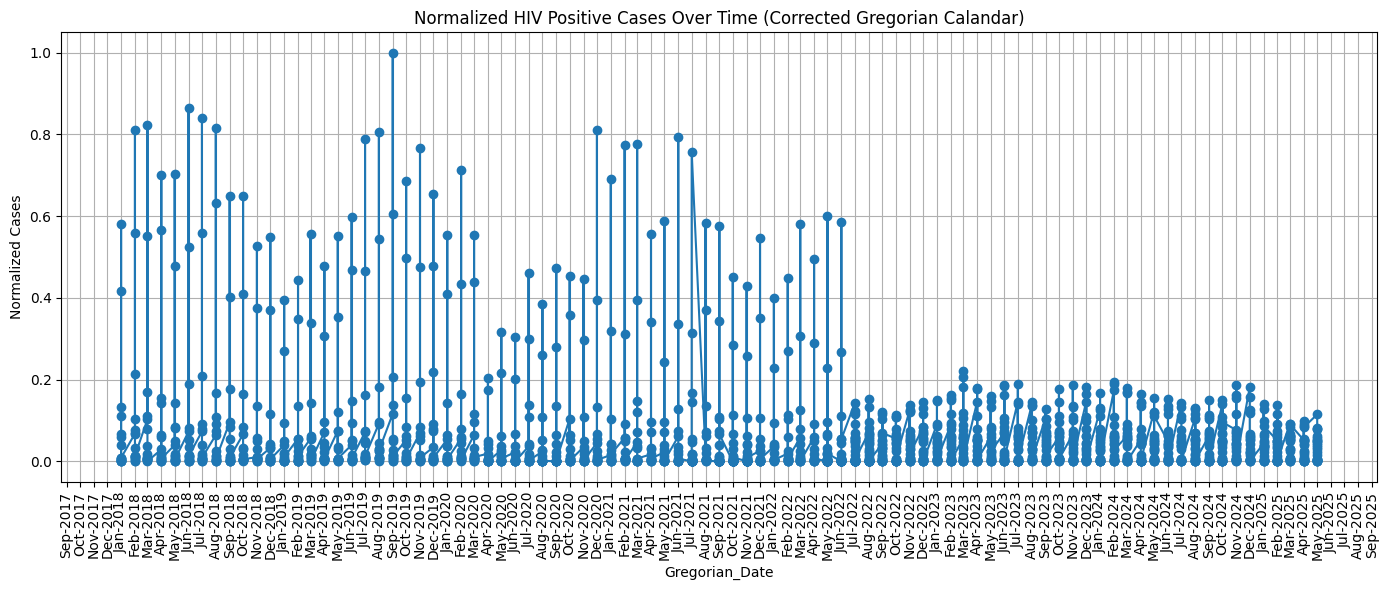

In [ ]:
# Correct Ethiopian-to-Gregorian month mapping
ethiopian_to_gregorian_month_map = {
    "Meskerem": 9, "Tikemet": 10, "Hidar": 11, "Tahesas": 12,
    "Tir": 1, "Yekatit": 2, "Megabit": 3, "Miazia": 4, "Miyaziya": 4,
    "Ginbot": 5, "Sene": 6, "Hamle": 7, "Nehase": 8
}

# Extract Ethiopian month and year
df_with_totals["Month"] = df_with_totals["periodname"].str.split(" ").str[0].map(ethiopian_to_gregorian_month_map)
df_with_totals["Ethiopian_Year"] = df_with_totals["periodname"].str.split(" ").str[1].astype(int)

# Apply correct year adjustment rule
def convert_to_gregorian(row):
    if row["Month"] >= 9:  # Meskerem to Tahesas (Gregorian Year same as Ethiopian Year +7)
        return row["Ethiopian_Year"] + 7
    else:  # Tir to Nehase (Gregorian Year same as Ethiopian Year +8)
        return row["Ethiopian_Year"] + 8

df_with_totals["Gregorian_Year"] = df_with_totals.apply(convert_to_gregorian, axis=1)

# Create accurate Gregorian datetime
df_with_totals["Gregorian_Date"] = pd.to_datetime(df_with_totals["Gregorian_Year"].astype(str) + "-" + df_with_totals["Month"].astype(str).str.zfill(2) + "-01")

# Create a combined positivity column across all facilities and modalities
df_with_totals["Positive_total"] = (
    df_with_totals["Total_Positive_Clinics_PITC"] +
    df_with_totals["Total_Positive_Clinics_VCT"] +
    df_with_totals["Total_Positive_HealthCenters_PITC"] +
    df_with_totals["Total_Positive_HealthCenters_VCT"] +
    df_with_totals["Total_Positive_Hospitals_PITC"] +
    df_with_totals["Total_Positive_Hospitals_VCT"]
)


# Sort and clean time series
# Use df_with_totals and the correct column name 'Positive_total'
df_ts = df_with_totals[["Gregorian_Date", "Positive_total"]].sort_values("Gregorian_Date")
df_ts.fillna(method="ffill", inplace=True)

# Normalize values
scaler = MinMaxScaler()
df_ts["Positive_total"] = scaler.fit_transform(df_ts[["Positive_total"]])

# Plot with properly aligned months
import matplotlib.dates as mdates # Import mdates
plt.figure(figsize=(14, 6))
plt.plot(df_ts["Gregorian_Date"], df_ts["Positive_total"], marker='o', linestyle='-')
plt.title("Normalized HIV Positive Cases Over Time (Corrected Gregorian Calandar)")
plt.xlabel("Gregorian_Date")
plt.ylabel("Normalized Cases")
plt.grid(True)

# Ensure all months are correctly displayed
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Create a combined positivity column across all facilities and modalities
df_with_totals["Positive_total"] = (
    df_with_totals["Total_Positive_Clinics_PITC"] +
    df_with_totals["Total_Positive_Clinics_VCT"] +
    df_with_totals["Total_Positive_HealthCenters_PITC"] +
    df_with_totals["Total_Positive_HealthCenters_VCT"] +
    df_with_totals["Total_Positive_Hospitals_PITC"] +
    df_with_totals["Total_Positive_Hospitals_VCT"]
)

# Sort and clean time series
df_ts = df_with_totals[["Gregorian_Date", "Positive_total"]].sort_values("Gregorian_Date")
df_ts.fillna(method="ffill", inplace=True)

# Optional: Preview the cleaned time series
print(df_ts.head())

   Gregorian_Date  Positive_total
0      2018-01-01             0.0
15     2018-01-01            34.0
14     2018-01-01            64.0
13     2018-01-01           333.0
12     2018-01-01           239.0


/tmp/ipython-input-27-3065083568.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ts.fillna(method="ffill", inplace=True)


/tmp/ipython-input-28-2036212444.py:9: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


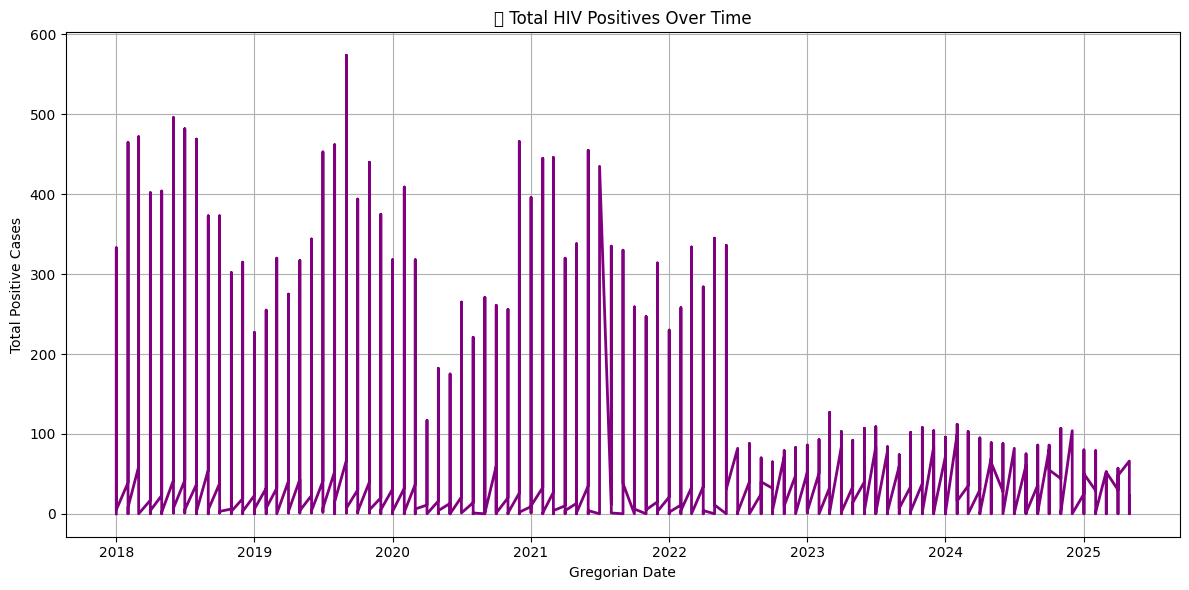

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_ts["Gregorian_Date"], df_ts["Positive_total"], color='purple', linewidth=2)
plt.title("📈 Total HIV Positives Over Time")
plt.xlabel("Gregorian Date")
plt.ylabel("Total Positive Cases")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Convert Numeric Columns
# Here we assume that the first four columns are identifiers.
#setting up data preprocessing workflow
numeric_cols = df.columns[4:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
identifier_cols = ['periodname', 'categoryoptioncomboname', 'AgeBand', 'Sex']
numeric_cols = [col for col in df.columns if col not in identifier_cols]
df.fillna(0, inplace=True)   # Fill All Blank or NaN Cells with Zero
def generate_totals_from_config(df, config_df):
    """
    Dynamically creates total columns in the DataFrame based on config info.
    Returns a modified copy of the DataFrame with added columns.

    Parameters:
    - df: main data table (e.g., your wide HIV dataset)
    - config_df: the configuration table with columns:
        'Modality', 'Facility_Type', 'Outcome', 'Column_Name'
    """
    df = df.copy()

In [ ]:
print(summary['periodname'].head(10))

0    Ginbot 2010
1    Ginbot 2010
2    Ginbot 2010
3    Ginbot 2010
4    Ginbot 2010
5    Ginbot 2010
6    Ginbot 2010
7    Ginbot 2010
8    Ginbot 2011
9    Ginbot 2011
Name: periodname, dtype: object


/tmp/ipython-input-31-1513545264.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


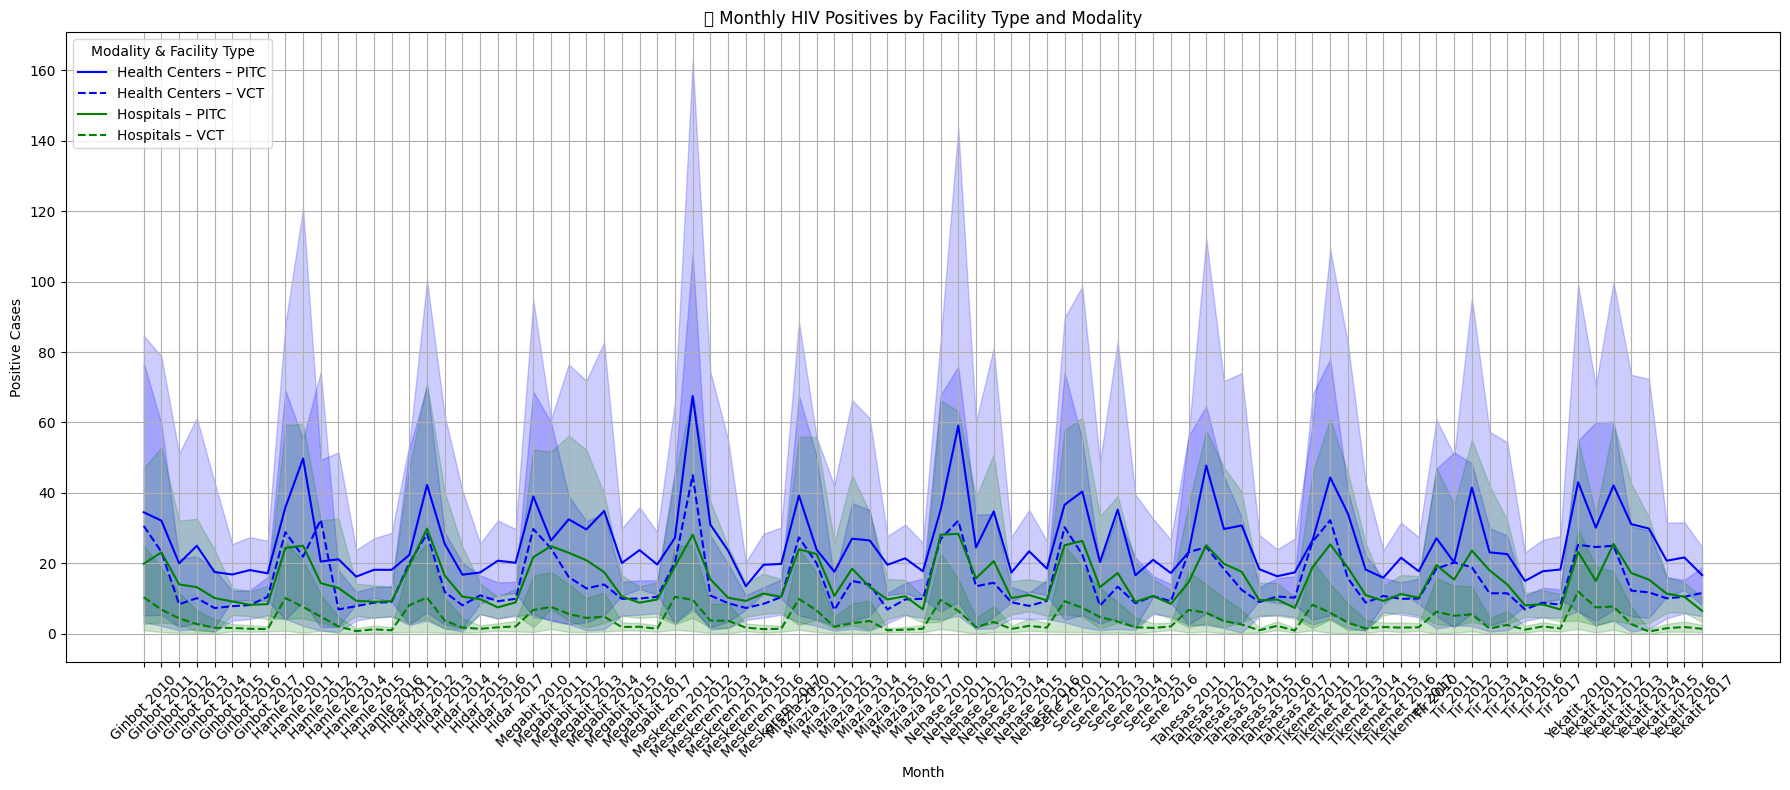

In [ ]:
#Aggregating data by facility type
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 8))

# 🏥 Health Centers
sns.lineplot(data=summary, x='periodname', y='Total_Positive_HealthCenters_PITC',
             label='Health Centers – PITC', color='blue', linestyle='-')
sns.lineplot(data=summary, x='periodname', y='Total_Positive_HealthCenters_VCT',
             label='Health Centers – VCT', color='blue', linestyle='--')

# 🏥 Hospitals
sns.lineplot(data=summary, x='periodname', y='Total_Positive_Hospitals_PITC',
             label='Hospitals – PITC', color='green', linestyle='-')
sns.lineplot(data=summary, x='periodname', y='Total_Positive_Hospitals_VCT',
             label='Hospitals – VCT', color='green', linestyle='--')

# 🏥 Health Posts (if available)
if 'Total_Positive_HealthPosts_PITC' in summary.columns:
    sns.lineplot(data=summary, x='periodname', y='Total_Positive_HealthPosts_PITC',
                 label='Health Posts – PITC', color='orange', linestyle='-')
if 'Total_Positive_HealthPosts_VCT' in summary.columns:
    sns.lineplot(data=summary, x='periodname', y='Total_Positive_HealthPosts_VCT',
                 label='Health Posts – VCT', color='orange', linestyle='--')

# 🧾 Final touches
plt.title("📈 Monthly HIV Positives by Facility Type and Modality")
plt.xlabel("Month")
plt.ylabel("Positive Cases")
plt.xticks(rotation=45)
plt.legend(title="Modality & Facility Type", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-32-1631564208.py:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


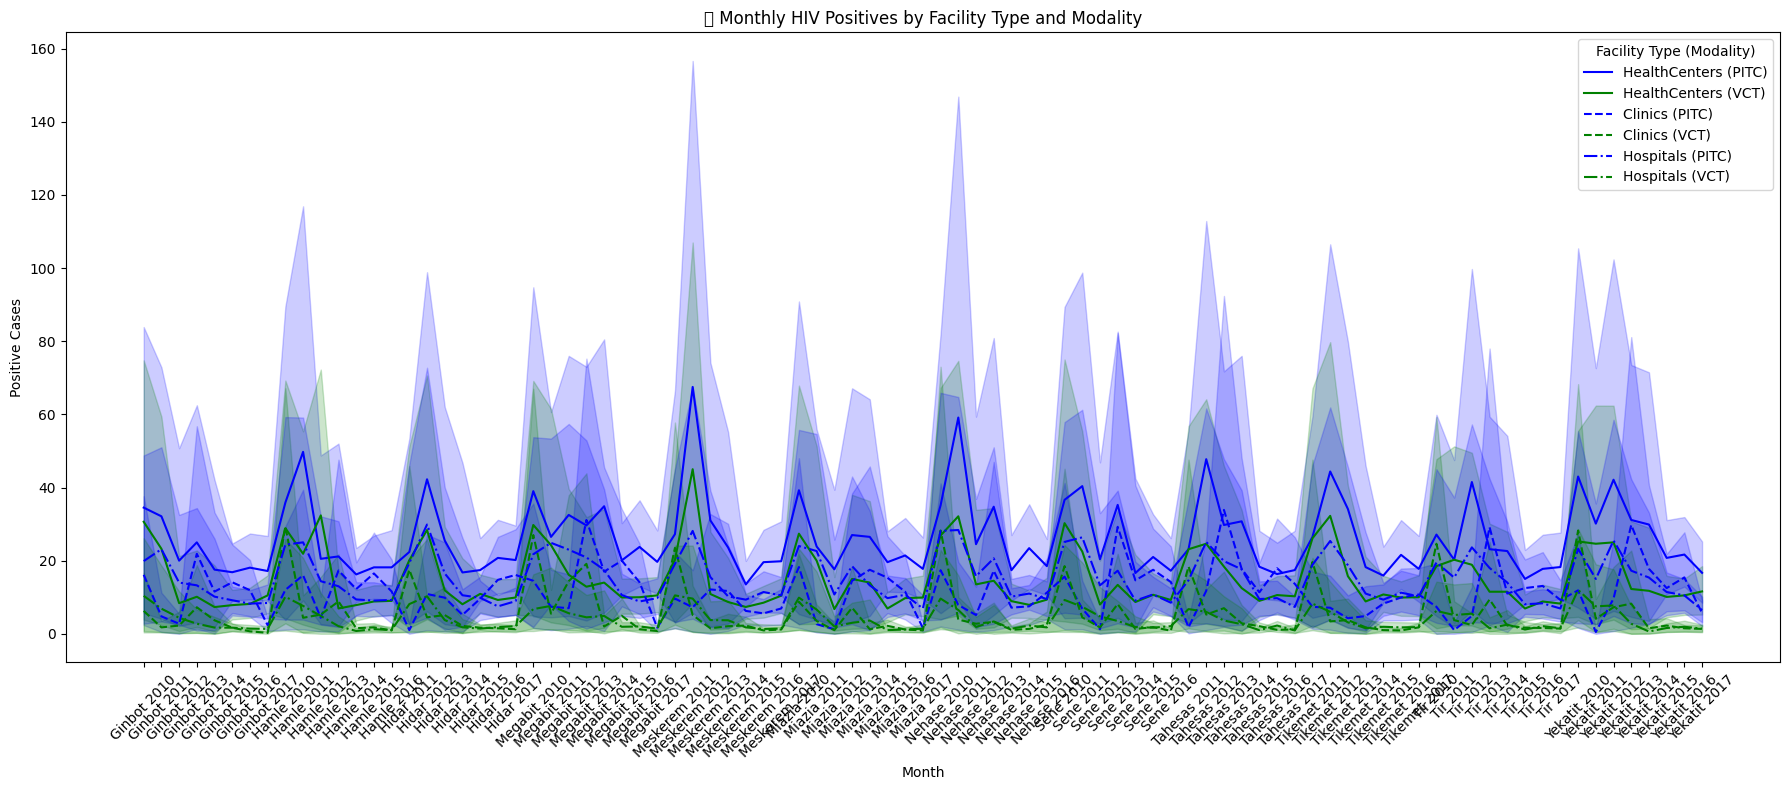

In [ ]:
#sample visualization of trends
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 8))

facilities = ['HealthCenters', 'Clinics', 'Hospitals']
modalities = ['PITC', 'VCT']
colors = {'PITC': 'blue', 'VCT': 'green'}
linestyles = {'HealthCenters': '-', 'Clinics': '--', 'Hospitals': '-.'}

for facility in facilities:
    for modality in modalities:
        column_name = f'Total_Positive_{facility}_{modality}'
        if column_name in summary.columns:
            sns.lineplot(data=summary, x='periodname', y=column_name,
                         label=f'{facility} ({modality})',
                         color=colors[modality],
                         linestyle=linestyles[facility])
        else:
            print(f"Warning: Column '{column_name}' not found in summary DataFrame.")


plt.title("📈 Monthly HIV Positives by Facility Type and Modality")
plt.xlabel("Month")
plt.ylabel("Positive Cases")
plt.xticks(rotation=45)
plt.legend(title='Facility Type (Modality)')
plt.tight_layout()
plt.show()

In [ ]:
# Assuming the modified DataFrame is named df_with_totals
# and contains total columns like:
# 'Total_Positive_HealthCenters_PITC', 'Total_Positive_Hospitals_VCT', etc.

# Define facility types and modalities
facilities = ['HealthCenters', 'Clinics', 'Hospitals']
modalities = ['PITC', 'VCT']

# Build list of valid total columns based on existing ones
valid_columns = []
for f in facilities:
    for m in modalities:
        col = f"Total_Positive_{f}_{m}"
        if col in df_with_totals.columns:
            valid_columns.append(col)

# Summarize by period and age band
summary = df_with_totals.groupby(['periodname', 'AgeBand'])[valid_columns].sum().reset_index()

# Add a grand total column summing across facilities and modalities
summary['Grand_Total_Positive'] = summary[valid_columns].sum(axis=1)

# Display or export the result
summary.head()  # Preview

,periodname,AgeBand,Total_Positive_HealthCenters_PITC,Total_Positive_HealthCenters_VCT,Total_Positive_Clinics_PITC,Total_Positive_Clinics_VCT,Total_Positive_Hospitals_PITC,Total_Positive_Hospitals_VCT,Grand_Total_Positive
0,Ginbot 2010,1 - 4 years,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,Ginbot 2010,10 - 14 Years,7.0,4.0,3.0,1.0,2.0,0.0,17.0
2,Ginbot 2010,15 - 19 Years,11.0,12.0,4.0,4.0,2.0,2.0,35.0
3,Ginbot 2010,20 - 24 Years,35.0,30.0,16.0,3.0,8.0,13.0,105.0
4,Ginbot 2010,25 - 49 Years,196.0,184.0,86.0,42.0,108.0,62.0,678.0


In [ ]:
#Summurize  monthly positives

In [ ]:
def summarize_monthly_positives(df, facilities, modality, output_path=None):
    """
    Summarizes total positive cases by month and age band for selected facilities and modality.

    Parameters:
        df (DataFrame): Your dataset with Total_* columns generated.
        facilities (list): Facility types to include (e.g., ['HealthCenters', 'Clinics']).
        modality (str): Either 'PITC' or 'VCT'.
        output_path (str, optional): If provided, saves summary to Excel at this path.

    Returns:
        DataFrame: Summarized monthly totals.
    """
    summary_cols = [f'Total_Positive_{facility}_{modality}' for facility in facilities]
    group_cols = ['periodname', 'AgeBand']

    # Check for missing columns and warn
    missing = [col for col in summary_cols if col not in df.columns]
    if missing:
        print("Missing columns:", missing)
        return None

    # Group and summarize
    summary = df.groupby(group_cols)[summary_cols].sum().reset_index()

    # Optionally export
    if output_path:
        summary.to_excel(output_path, index=False)
        print(f" Summary saved to: {output_path}")

    return summary
    summary.head()

In [ ]:
# Define summary
facilities = ['HealthCenters', 'Clinics', 'Hospitals']
modalities = ['PITC', 'VCT']

# Dynamically find matching columns that exist in df_with_totals
valid_columns = []
for f in facilities:
    for m in modalities:
        col_name = f"Total_Positive_{f}_{m}"
        if col_name in df_with_totals.columns:
            valid_columns.append(col_name)
        else:
            print(f"Skipping missing column: {col_name}")

# Group by periodname and AgeBand, then summarize only valid columns
summary_df = df_with_totals.groupby(['periodname', 'AgeBand'])[valid_columns].sum().reset_index()

# Save or preview the result
summary_df.to_csv("/content/Latest_July15_monthly_summary_cleaned.csv", index=False)
summary_df.head()

,periodname,AgeBand,Total_Positive_HealthCenters_PITC,Total_Positive_HealthCenters_VCT,Total_Positive_Clinics_PITC,Total_Positive_Clinics_VCT,Total_Positive_Hospitals_PITC,Total_Positive_Hospitals_VCT
0,Ginbot 2010,1 - 4 years,0.0,0.0,0.0,0.0,1.0,0.0
1,Ginbot 2010,10 - 14 Years,7.0,4.0,3.0,1.0,2.0,0.0
2,Ginbot 2010,15 - 19 Years,11.0,12.0,4.0,4.0,2.0,2.0
3,Ginbot 2010,20 - 24 Years,35.0,30.0,16.0,3.0,8.0,13.0
4,Ginbot 2010,25 - 49 Years,196.0,184.0,86.0,42.0,108.0,62.0


In [ ]:
print(df_with_totals[valid_columns].sum())

Total_Positive_HealthCenters_PITC    21862.0
Total_Positive_HealthCenters_VCT     12311.0
Total_Positive_Clinics_PITC          10081.0
Total_Positive_Clinics_VCT            4296.0
Total_Positive_Hospitals_PITC        12464.0
Total_Positive_Hospitals_VCT          3075.0
dtype: float64


In [ ]:
# Ethiopian to Gregorian month mapping
ethiopian_to_gregorian_month_map = {
    "Meskerem": 9, "Tikemet": 10, "Hidar": 11, "Tahesas": 12,
    "Tir": 1, "Yekatit": 2, "Megabit": 3, "Miazia": 4, "Miyaziya": 4,
    "Ginbot": 5, "Sene": 6, "Hamle": 7, "Nehase": 8
}

In [ ]:
# Extract month and year from 'periodname'
df["Month"] = df["periodname"].str.split(" ").str[0].map(ethiopian_to_gregorian_month_map)

def extract_year(period):
    try:
        return int(period.split(" ")[1])
    except (IndexError, ValueError):
        return np.nan
df["Ethiopian_Year"] = df["periodname"].apply(extract_year)
df.dropna(subset=["Ethiopian_Year"], inplace=True)
df["Ethiopian_Year"] = df["Ethiopian_Year"].astype(int)



In [ ]:
df["Month"] = df["periodname"].str.split(" ").str[0]




In [ ]:
# Apply Gregorian year conversion
def convert_to_gregorian(row):
    # Map month name to its numerical value
    month_num = ethiopian_to_gregorian_month_map[row["Month"]]
    if month_num >= 9:  # Meskerem to Tahesas
        return row["Ethiopian_Year"] + 7
    else:  # Tir to Nehase
        return row["Ethiopian_Year"] + 8

df["Gregorian_Year"] = df.apply(convert_to_gregorian, axis=1)

In [ ]:
ethiopian_months = {
    "Meskerem": 1, "Tikimt": 2, "Hidar": 3, "Tahesas": 4,
    "Tir": 5, "Yekatit": 6, "Megabit": 7, "Miyazya": 8, "Miazia": 8,
    "Ginbot": 9, "Sene": 10, "Hamle": 11, "Nehase": 12, "Pagumen": 13
}
df["Month"] = df["periodname"].str.split(" ").str[0].map(ethiopian_months)

In [ ]:
def convert_to_gregorian(row):
    if row["Month"] >= 9:  # Meskerem to Tahesas
        return row["Ethiopian_Year"] + 7
    else:  # Tir to Nehase
        return row["Ethiopian_Year"] + 8

df["Gregorian_Year"] = df.apply(convert_to_gregorian, axis=1)


In [ ]:
# Build a clean Gregorian date string
df["Gregorian_Date"] = pd.to_datetime(
    df["Gregorian_Year"].astype(str) + "-" +
    df["Month"].astype(str).str.zfill(2) + "-01",
    format='%Y-%m-%d', # Specify the format
    errors='coerce'  # avoid crashing on invalid strings
)

In [ ]:
print(df.columns.tolist())

['periodid', 'periodname', 'periodcode', 'categoryoptioncomboid', 'categoryoptioncomboname', 'Clinics -2017_HIV_Clients receiving HIV test results (at PITC)', 'Clinics HIV_Clients receiving HIV test results (at PITC)', 'Clinics -2017_HIV_Clients receiving HIV test results (at VCT)', 'Clinics HIV_Clients receiving HIV test results (at VCT)', 'Clinics -2017_HIV_Clients testing positive for HIV (at PITC)', 'Clinics HIV_Clients testing positive for HIV (at PITC)', 'Clinics -2017_HIV_Clients testing positive for HIV (at VCT)', 'Clinics HIV_Clients testing positive for HIV (at VCT)', 'Health Centers -2017_HIV_Clients receiving HIV test results (at PITC)', 'Health Centers HIV_Clients receiving HIV test results (at PITC)', 'Health Centers -2017_HIV_Clients receiving HIV test results (at VCT)', 'Health Centers HIV_Clients receiving HIV test results (at VCT)', 'Health Centers -2017_HIV_Clients testing positive for HIV (at PITC)', 'Health Centers HIV_Clients testing positive for HIV (at PITC)', '

In [ ]:
#Generate and Configure Totals

In [ ]:
# --- Define config_df and generate_totals_from_config function ---
import pandas as pd
import numpy as np

# Define config_df
config_data = [
    ['PITC', 'Clinics', 'Tested',  'Clinics -2017_HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Clinics', 'Tested',  'Clinics HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Clinics', 'Positive','Clinics -2017_HIV_Clients testing positive for HIV (at PITC)'],
    ['PITC', 'Clinics', 'Positive','Clinics HIV_Clients testing positive for HIV (at PITC)'],

    ['VCT',  'Clinics', 'Tested',  'Clinics -2017_HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Clinics', 'Tested',  'Clinics HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Clinics', 'Positive','Clinics -2017_HIV_Clients testing positive for HIV (at VCT)'],
    ['VCT',  'Clinics', 'Positive','Clinics HIV_Clients testing positive for HIV (at VCT)'],

    ['PITC', 'Health Centers', 'Tested',  'Health Centers -2017_HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Health Centers', 'Tested',  'Health Centers HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Health Centers', 'Positive','Health Centers -2017_HIV_Clients testing positive for HIV (at PITC)'],
    ['PITC', 'Health Centers', 'Positive','Health Centers HIV_Clients testing positive for HIV (at PITC)'],

    ['VCT',  'Health Centers', 'Tested',  'Health Centers HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Health Centers', 'Tested',  'Health Centers HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Health Centers', 'Positive','Health Centers -2017_HIV_Clients testing positive for HIV (at PITC)'],
    ['VCT',  'Health Centers', 'Positive','Health Centers HIV_Clients testing positive for HIV (at PITC)'],

    ['PITC', 'Hospitals', 'Tested',  'Hospitals -2017_HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Hospitals', 'Tested',  'Hospitals HIV_Clients receiving HIV test results (at PITC)'],
    ['PITC', 'Hospitals', 'Positive','Hospitals -2017_HIV_Clients testing positive for HIV (at PITC)'],
    ['PITC', 'Hospitals', 'Positive','Hospitals HIV_Clients testing positive for HIV (at PITC)'],

    ['VCT',  'Hospitals', 'Tested',  'Hospitals HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Hospitals', 'Tested',  'Hospitals HIV_Clients receiving HIV test results (at VCT)'],
    ['VCT',  'Hospitals', 'Positive','Hospitals -2017_HIV_Clients testing positive for HIV (at VCT)'],
    ['VCT',  'Hospitals', 'Positive','Hospitals HIV_Clients testing positive for HIV (at VCT)'],
]
config_df = pd.DataFrame(config_data, columns=['Modality', 'Facility_Type', 'Outcome', 'Column_Name'])


# Define generate_totals_from_config function (including the return statement fix)
def generate_totals_from_config(df, config_df):
    """
    Dynamically creates total columns in the DataFrame based on config info.
    Returns a modified copy of the DataFrame with added columns.

    Parameters:
    - df: main data table (e.g., your wide HIV dataset)
    - config_df: the configuration table with columns:
        'Modality', 'Facility_Type', 'Outcome', 'Column_Name'
    """
    df = df.copy()
    # Identify unique groupings
    grouping_keys = config_df[['Facility_Type', 'Modality', 'Outcome']].drop_duplicates()

    for _, row in grouping_keys.iterrows():
        facility = row['Facility_Type']
        modality = row['Modality']
        outcome = row['Outcome']

        # Create a clean column label
        col_label = f"Total_{outcome}_{facility.replace(' ', '')}_{modality}"

        # Find matching columns in config
        match_cols = config_df.loc[
            (config_df['Facility_Type'] == facility) &
            (config_df['Modality'] == modality) &
            (config_df['Outcome'] == outcome),
            'Column_Name'
        ].tolist()

        if match_cols:  # Ensure there are columns to sum
            # Ensure columns exist in df before summing
            existing_cols = [col for col in match_cols if col in df.columns]
            if existing_cols:
                # Fill NaN values with 0 for summation
                df[col_label] = df[existing_cols].fillna(0).sum(axis=1)
            else:
                df[col_label] = 0  # Default to zero if no matching columns in df
        else:
            df[col_label] = 0  # Default to zero if no matching columns in config

    return df
# --- End of defining config_df and generate_totals_from_config function ---


# --- Create df and df_with_totals ---
# load csv file into df
df = pd.read_csv("/content/extracted_folder/hiv_zip/aa_hiv_data_final_2025.csv")

# Apply the dynamic total generator
df_with_totals = generate_totals_from_config(df, config_df)

# Add AgeBand and Sex columns to df_with_totals
if 'categoryoptioncomboname' in df_with_totals.columns:
    df_with_totals['categoryoptioncomboname'] = df_with_totals['categoryoptioncomboname'].astype(str).str.strip() # Ensure string type
    split_cols = df_with_totals['categoryoptioncomboname'].str.split(',', expand=True)
    if split_cols.shape[1] >= 2:
        df_with_totals['AgeBand'] = split_cols[0].str.strip()
        df_with_totals['Sex'] = split_cols[1].str.strip()
    else:
        df_with_totals['AgeBand'] = np.nan
        df_with_totals['Sex'] = np.nan
# --- End of creating df_with_totals ---

# Ethiopian to Gregorian month mapping
ethiopian_to_gregorian_month_map = {
    "Meskerem": 9, "Tikemet": 10, "Hidar": 11, "Tahesas": 12,
    "Tir": 1, "Yekatit": 2, "Megabit": 3, "Miazia": 4, "Miyaziya": 4,
    "Ginbot": 5, "Sene": 6, "Hamle": 7, "Nehase": 8
}

# Extract month and year from 'periodname'
df_with_totals["Month"] = df_with_totals["periodname"].str.split(" ").str[0].map(ethiopian_to_gregorian_month_map)

def extract_year(period):
    try:
        return int(period.split(" ")[1])
    except (IndexError, ValueError):
        return np.nan

df_with_totals["Ethiopian_Year"] = df_with_totals["periodname"].apply(extract_year)
df_with_totals.dropna(subset=["Ethiopian_Year"], inplace=True)
df_with_totals["Ethiopian_Year"] = df_with_totals["Ethiopian_Year"].astype(int)

# Apply Gregorian year conversion
def convert_to_gregorian(row):
    # Map month name to its numerical value
    month_num = ethiopian_to_gregorian_month_map[row["periodname"].split(" ")[0]] # Use periodname to get month name
    if month_num >= 9:  # Meskerem to Tahesas
        return row["Ethiopian_Year"] + 7
    else:  # Tir to Nehase
        return row["Ethiopian_Year"] + 8

df_with_totals["Gregorian_Year"] = df_with_totals.apply(convert_to_gregorian, axis=1)

# Build a clean Gregorian date string
df_with_totals["Gregorian_Date"] = pd.to_datetime(
    df_with_totals["Gregorian_Year"].astype(str) + "-" +
    df_with_totals["Month"].astype(str).str.zfill(2) + "-01",
    format='%Y-%m-%d', # Specify the format
    errors='coerce'  # avoid crashing on invalid strings
)


# Define lists of columns for tested and positive counts (adjust according to your actual column names)
# Use the total columns generated from config_df
tested_columns = [
    "Total_Tested_Clinics_PITC",
    "Total_Tested_Clinics_VCT",
    "Total_Tested_HealthCenters_PITC",
    "Total_Tested_HealthCenters_VCT",
    "Total_Tested_Hospitals_PITC",
    "Total_Tested_Hospitals_VCT"
]

positive_columns = [
    "Total_Positive_Clinics_PITC",
    "Total_Positive_Clinics_VCT",
    "Total_Positive_HealthCenters_PITC",
    "Total_Positive_HealthCenters_VCT",
    "Total_Positive_Hospitals_PITC",
    "Total_Positive_Hospitals_VCT"
]

# Ensure these columns exist in df_with_totals
# Added a check here to see if df_with_totals is not None before accessing columns
if df_with_totals is not None:
    for col in tested_columns + positive_columns:
        if col not in df_with_totals.columns:
            print(f"Warning: {col} not found in df_with_totals.")

    # Create aggregate features in df_with_totals
    df_with_totals['Tested_total'] = df_with_totals[tested_columns].fillna(0).sum(axis=1) # Fill NaN with 0 before summing
    df_with_totals['Positive_total'] = df_with_totals[positive_columns].fillna(0).sum(axis=1) # Fill NaN with 0 before summing

    # Avoid division by zero – use np.where to handle zeros
    df_with_totals['Incidence'] = np.where(df_with_totals['Tested_total'] > 0,
                                 df_with_totals['Positive_total'] / df_with_totals['Tested_total'],
                                 0)

    # Aggregate data by period (you may want to average/ sum the counts)
    # Assuming 'periodname' uniquely identifies each time step for the time series
    grouped = df_with_totals.groupby("periodname").agg({
        'Tested_total': 'sum',
        'Positive_total': 'sum',
        'Incidence': 'mean' # Assuming you want the average incidence per period
    }).reset_index()

    # Sort by periodname. If periodname is not in a recognizable chronological order,
    # create an order index manually.
    # For demonstration, we assume the grouped rows are in the correct time order.
    #print("Grouped Data:\n", grouped)
else:
    print("Error: df_with_totals is None. Could not proceed with calculations.")

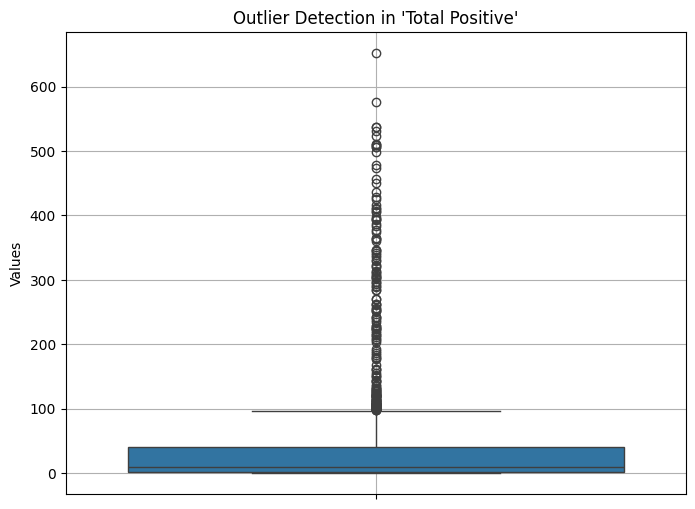

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a boxplot to visualize outliers
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_with_totals["Positive_total"])
plt.title("Outlier Detection in 'Total Positive'")
plt.ylabel("Values")
plt.grid(True)
plt.show()

In [ ]:
#Forcasting models:Modeldevelopment, trainning and Evaluation of metrics

In [ ]:
#import all important libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
#define Evaln Function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"\n📊 {model_name} Evaluation:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}")
    return {'Model': model_name, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

In [ ]:
#define DL builder
def build_and_train_dl_model(model_type, X_seq, y_seq, lookback, n_features):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(128, activation='relu', input_shape=(lookback, n_features)))
    elif model_type == 'GRU':
        model.add(GRU(128, activation='relu', input_shape=(lookback, n_features)))
    elif model_type == 'RNN':
        model.add(SimpleRNN(128, activation='relu', input_shape=(lookback, n_features)))
    elif model_type == 'Conv1D':
        model.add(Conv1D(64, kernel_size=2, activation='relu', input_shape=(lookback, n_features)))
        model.add(MaxPooling1D())
        model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

    train_size = int(len(X_seq) * 0.8)
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_test, y_test = X_seq[train_size:], y_seq[train_size:]

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train,
              epochs=50,
              batch_size=16,
              validation_split=0.2,
              callbacks=[early_stop],
              verbose=0)

    return model, X_test, y_test

In [ ]:
#LSTM+SARIMA
def train_sarima_lstm_hybrid(grouped_df, X_seq, y_seq, lookback, n_features):
    # Fit SARIMA on full series
    # Convert the relevant column from grouped_df to pandas Series with 'Gregorian_Date' as index
    if 'Gregorian_Date' in grouped_df.columns and 'Incidence' in grouped_df.columns:
        y_series_ts = grouped_df.set_index('Gregorian_Date')['Incidence']
        y_series_ts = y_series_ts.asfreq('MS').fillna(method='ffill') # Set frequency to Monthly Start
    else:
        print("Error: Required columns ('Gregorian_Date' or 'Incidence') not found in the input DataFrame.")
        return None # Return None or raise an error if essential columns are missing


    sarima_model = SARIMAX(y_series_ts, order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_results = sarima_model.fit(disp=False)

    # Split data for LSTM training
    train_size = int(len(X_seq) * 0.8)
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_test, y_test = X_seq[train_size:], y_seq[train_size:]

    # Forecast SARIMA for the test period
    sarima_forecast_test = sarima_results.predict(start=len(y_series_ts) - len(y_test), end=len(y_series_ts) - 1)

    # Calculate residuals for LSTM training
    # Align SARIMA forecast with the LSTM training target data
    sarima_forecast_train = sarima_results.predict(start=lookback, end=lookback + len(y_train) - 1)
    residuals_train = y_train.flatten() - sarima_forecast_train.values.flatten()
    residuals_train = residuals_train.reshape(-1, 1)

    # Build LSTM model to predict residuals
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(lookback, n_features)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train LSTM on residuals
    model.fit(X_train, residuals_train,
              epochs=50,
              batch_size=16,
              validation_split=0.2,
              callbacks=[early_stop],
              verbose=0)

    # Predict residuals for the test set
    lstm_residuals_test = model.predict(X_test).flatten()

    # Combine SARIMA forecast and LSTM residual prediction for the final forecast
    final_forecast_test = sarima_forecast_test.values.flatten() + lstm_residuals_test

    y_true_test = y_test.flatten() # Actual scaled test values

    # Inverse transform for evaluation
    y_true_test_inv = scaler_y.inverse_transform(y_true_test.reshape(-1, 1)).flatten()
    final_forecast_test_inv = scaler_y.inverse_transform(final_forecast_test.reshape(-1, 1)).flatten()


    # Evaluate
    mae = mean_absolute_error(y_true_test_inv, final_forecast_test_inv)
    mse = mean_squared_error(y_true_test_inv, final_forecast_test_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_test_inv, final_forecast_test_inv)
    mape = mean_absolute_percentage_error(y_true_test_inv, final_forecast_test_inv)

    print(f"\n📊 SARIMA+LSTM Hybrid Evaluation:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}")
    return {'Model': 'SARIMA+LSTM', 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

In [ ]:
#Conv1d+GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_conv1d_gru_model(lookback, n_features):
    model = Sequential()

    # Convolutional feature extractor
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    # GRU for temporal modeling
    model.add(GRU(128, activation='relu'))
    model.add(Dropout(0.3))

    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

    return model

In [ ]:
#Convert Numpy to array (to ensure compatibility, performance, and consistency
#Important in HIV predection using DL models )

In [ ]:
import numpy as np

# Example: assuming 'df' is DataFrame and 'target' is the column to forecast

data = df.values  # Convert to NumPy array

In [ ]:
def create_sequences(X, y, lookback=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback, :])  # all features
        y_seq.append(y[i+lookback])     # target variable
    return np.array(X_seq), np.array(y_seq)

# Apply sequence generator
lookback = 3
# Assuming 'grouped' DataFrame and 'features' and 'target' arrays are already defined and scaled
# in the previous cells
if 'features_scaled' in locals() and 'target_scaled' in locals():
    X_seq, y_seq = create_sequences(features_scaled, target_scaled, lookback)
    n_features = X_seq.shape[2]
    print(f"Created sequences with shape X_seq: {X_seq.shape}, y_seq: {y_seq.shape}")
else:
    print("Error: 'features_scaled' or 'target_scaled' not found. Please run previous cells.")
    # optional- load or create the data here if running this cell independently

Error: 'features_scaled' or 'target_scaled' not found. Please run previous cells.


In [ ]:
train_size = int(len(X_seq) * 0.8)
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_test, y_test = X_seq[train_size:], y_seq[train_size:]

In [ ]:
# Ensure 'Gregorian_Date' exists in df_with_totals
if 'Gregorian_Date' not in df_with_totals.columns:
    raise ValueError("The column 'Gregorian_Date' is missing from df_with_totals.")

# Rebuild grouped with Gregorian_Date preserved
grouped = df_with_totals[['Gregorian_Date', 'Tested_total', 'Positive_total', 'Incidence']].copy()
grouped.dropna(subset=['Gregorian_Date'], inplace=True)

# Aggregate by Gregorian_Date
grouped = grouped.groupby('Gregorian_Date').agg({
    'Tested_total': 'sum',
    'Positive_total': 'sum',
    'Incidence': 'mean'
}).reset_index().sort_values('Gregorian_Date')

In [ ]:
print(grouped.columns.tolist())

['Gregorian_Date', 'Tested_total', 'Positive_total', 'Incidence']


In [ ]:
['Gregorian_Date', 'Tested_total', 'Positive_total', 'Incidence']

['Gregorian_Date', 'Tested_total', 'Positive_total', 'Incidence']

In [ ]:
grouped_ts = grouped.set_index('Gregorian_Date')
grouped_ts = grouped_ts.asfreq('MS')  # Monthly frequency

In [ ]:
results = []
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Ensure data used for sequences is numeric
numeric_grouped = grouped.copy()
for col in ['Tested_total', 'Positive_total', 'Incidence']:
    numeric_grouped[col] = pd.to_numeric(numeric_grouped[col], errors='coerce')
numeric_grouped.fillna(0, inplace=True) # Fill any NaNs created by coercion


# Re-create sequences using the cleaned numeric data
features = numeric_grouped[['Tested_total', 'Positive_total']].values
target = numeric_grouped['Incidence'].values.reshape(-1, 1)

# Re-scale the input features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
target_scaled = scaler_y.fit_transform(target)

# Re-create sequences with the scaled numeric data
lookback = 3
X_seq, y_seq = create_sequences(features_scaled, target_scaled, lookback)
n_features = X_seq.shape[2]

# Split data for training and testing
train_size = int(len(X_seq) * 0.8)
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_test, y_test = X_seq[train_size:], y_seq[train_size:]

# Dictionary to store trained models
trained_models = {}

for model_type in ['RNN', 'GRU', 'LSTM', 'Conv1D']:
    print(f"Building and training {model_type} model...")
    # Pass scaler_y to build_and_train_dl_model for inverse transform in evaluation
    model, X_test_subset, y_test_subset = build_and_train_dl_model(model_type, X_seq, y_seq, lookback, n_features)
    trained_models[model_type] = model # Store the trained model

    # Pass scaler_y to evaluate_model for correct inverse transformation
    # Evaluate the model using the correct test subset and scaler
    y_pred_scaled = model.predict(X_test_subset)
    y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)
    y_test_inv = scaler_y.inverse_transform(y_test_subset)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

    print(f"\n📊 {model_type} Evaluation:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.4f}")
    results.append({'Model': model_type, 'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'MAPE': mape})


# Handle Conv1D+GRU separately as it has a dedicated build function
print("\nBuilding and training Conv1D+GRU model...")
model_conv1d_gru = build_conv1d_gru_model(lookback, n_features)
trained_models['Conv1D+GRU'] = model_conv1d_gru # Store the trained model

# Use the already split training and testing data
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_conv1d_gru.fit(X_train, y_train,
          epochs=50,
          batch_size=16,
          validation_split=0.2,
          callbacks=[early_stop],
          verbose=0)

# Evaluate Conv1D+GRU - need to pass scaler_y
y_pred_conv1d_gru_scaled = model_conv1d_gru.predict(X_test)
y_pred_conv1d_gru_inv = scaler_y.inverse_transform(y_pred_conv1d_gru_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)


mae_conv1d_gru = mean_absolute_error(y_test_inv, y_pred_conv1d_gru_inv)
mse_conv1d_gru = mean_squared_error(y_test_inv, y_pred_conv1d_gru_inv)
rmse_conv1d_gru = np.sqrt(mse_conv1d_gru)
r2_conv1d_gru = r2_score(y_test_inv, y_pred_conv1d_gru_inv)
mape_conv1d_gru = mean_absolute_percentage_error(y_test_inv, y_pred_conv1d_gru_inv)

print(f"\n📊 Conv1D+GRU Evaluation:")
print(f"MAE: {mae_conv1d_gru:.4f}, MSE: {mse_conv1d_gru:.4f}, RMSE: {rmse_conv1d_gru:.4f}, R²: {r2_conv1d_gru:.4f}, MAPE: {mape_conv1d_gru:.4f}")
results.append({'Model': 'Conv1D+GRU', 'MAE': mae_conv1d_gru, 'MSE': mse_conv1d_gru, 'RMSE': rmse_conv1d_gru, 'R2': r2_conv1d_gru, 'MAPE': mape_conv1d_gru})


# SARIMA+LSTM hybrid
# Need to prepare y_series for SARIMA
# Assuming y_seq represents the target series
# Use the original scaled target before sequence creation for SARIMA fitting
y_series_numeric = pd.to_numeric(grouped['Incidence'], errors='coerce').fillna(0)

# Set 'Gregorian_Date' as index for the time series data for SARIMA
grouped_ts = grouped.set_index('Gregorian_Date')


print("\nBuilding and training SARIMA+LSTM hybrid model...")
# Pass the time series DataFrame with Gregorian_Date as index to train_sarima_lstm_hybrid
sarima_lstm_metrics = train_sarima_lstm_hybrid(grouped_ts.reset_index(), X_seq, y_seq, lookback, n_features)
results.append(sarima_lstm_metrics)


# Final summary
import pandas as pd
results_df = pd.DataFrame(results)
print("\n📋 Final Model Comparison Summary:")
print(results_df.round(4).to_string(index=False))

Building and training RNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

📊 RNN Evaluation:
MAE: 0.0022, MSE: 0.0000, RMSE: 0.0029, R²: -1.4800, MAPE: 0.1902
Building and training GRU model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

📊 GRU Evaluation:
MAE: 0.0016, MSE: 0.0000, RMSE: 0.0024, R²: -0.6107, MAPE: 0.1416
Building and training LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step

📊 LSTM Evaluation:
MAE: 0.0015, MSE: 0.0000, RMSE: 0.0020, R²: -0.1067, MAPE: 0.1217
Building and training Conv1D model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

📊 Conv1D Evaluation:
MAE: 0.0016, MSE: 0.0000, RMSE: 0.0020, R²: -0.1356, MAPE: 0.1274

Building and training Conv1D+GRU model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step

📊 Conv1D+GRU Evaluation:
MAE: 0.0020, MSE: 0.0000, RMSE: 0.0027, R²: -1.0475, MAPE: 0.1710

Building and training SARIMA+LSTM hybrid model...


/tmp/ipython-input-53-1020942659.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_series_ts = y_series_ts.asfreq('MS').fillna(method='ffill') # Set frequency to Monthly Start
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step

📊 SARIMA+LSTM Hybrid Evaluation:
MAE: 0.0030, MSE: 0.0000, RMSE: 0.0035, R²: -2.5911, MAPE: 0.2453

📋 Final Model Comparison Summary:
      Model    MAE  MSE   RMSE      R2   MAPE
        RNN 0.0022  0.0 0.0029 -1.4800 0.1902
        GRU 0.0016  0.0 0.0024 -0.6107 0.1416
       LSTM 0.0015  0.0 0.0020 -0.1067 0.1217
     Conv1D 0.0016  0.0 0.0020 -0.1356 0.1274
 Conv1D+GRU 0.0020  0.0 0.0027 -1.0475 0.1710
SARIMA+LSTM 0.0030  0.0 0.0035 -2.5911 0.2453


In [ ]:
print(grouped.columns.tolist())

['periodname', 'Tested_total', 'Positive_total', 'Incidence']


In [ ]:
# Final Model Comparison Summary
import pandas as pd

# Use the results_df DataFrame generated in cell zCgY9L0G7w6S
# Assuming that cell has been executed successfully and results_df is available
if 'results_df' in locals():
    print("\n Final Model Comparison Summary:")
    print(results_df.round(4).to_string(index=False))
else:
    print("Error: 'results_df' not found. Please ensure cell zCgY9L0G7w6S has been executed successfully.")

Error: 'results_df' not found. Please ensure cell zCgY9L0G7w6S has been executed successfully.


In [ ]:
# Export to CSV
results_df.round(4).to_csv("Final_July 15_model_comparison_summary.csv", index=False)

# Export to Excel
results_df.round(4).to_excel("Final July15_model_comparison_summary.xlsx", index=False)

In [ ]:
# Further steps in Prediction of  cases based on the modelare listed below
# Overestimation is observed in prediction using models like LSTM
# we need to consider LSTM complexity,modifying epochto 100,introducing additional features(age band and facility type )

## **Further steps in Prediction of  cases based on the modelare listed below**
## **Overestimation** is observed in prediction using models like LSTM **
## **we need to consider LSTM complexity,modifying epochto 100,introducing additional features(age band and facility type )**

In [ ]:
# LSTM trainning and prediction
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# --- Data Preparation
# Prepare data for time series forecasting (using Total Positive cases as the target)
# 'Tested_total' and 'Positive_total' as features and Incidence as our target.
# Ensure 'grouped' DataFrame is available from previous steps
# If 'grouped' is not available, you might need to re-run the Feature Engineering section.
if 'grouped' not in locals():
    print("Error: 'grouped' DataFrame not found. Please run the Feature Engineering section.")
else:
    features = grouped[['Tested_total', 'Positive_total']].values
    target = grouped['Incidence'].values.reshape(-1, 1)

    # Scale the input features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    features_scaled = scaler_X.fit_transform(features)
    target_scaled = scaler_y.fit_transform(target)

    # Define a lookback window (number of past time steps to use for prediction)
    lookback = 3

    # Function to create sequences for time series models
    def create_sequences(X, y, lookback):
        X_seq, y_seq = [], []
        for i in range(len(X) - lookback):
            X_seq.append(X[i:i+lookback, :])
            y_seq.append(y[i+lookback])
        return np.array(X_seq), np.array(y_seq)

    X_seq, y_seq = create_sequences(features_scaled, target_scaled, lookback)
    print(f"Original sequence shape: {X_seq.shape}, Target shape: {y_seq.shape}")

    # Split the sequences into training and test sets (e.g., 80% training)
    train_size = int(len(X_seq) * 0.8)
    X_train, y_train = X_seq[:train_size], y_seq[:train_size]
    X_test, y_test = X_seq[train_size:], y_seq[train_size:]

    print(f"Training sequence shape: {X_train.shape}, Training target shape: {y_train.shape}")
    print(f"Testing sequence shape: {X_test.shape}, Testing target shape: {y_test.shape}")

    # --- End of Data Preparation ---

    # Define input shape
    n_features = X_seq.shape[2]

    # Build the model
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(lookback, n_features)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

    # Summary
    model.summary()

    # Define early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

Original sequence shape: (86, 3, 2), Target shape: (86, 1)
Training sequence shape: (68, 3, 2), Training target shape: (68, 1)
Testing sequence shape: (18, 3, 2), Testing target shape: (18, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,441 (302.50 KB)

 Trainable params: 77,441 (302.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.4324 - val_loss: 0.2224
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3578 - val_loss: 0.1612
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3193 - val_loss: 0.0839
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2373 - val_loss: 0.0513
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1624 - val_loss: 0.1482
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1648 - val_loss: 0.2037
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1781 - val_loss: 0.1668
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1681 - val_loss: 0.1183
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1543 - val_loss: 0.0920
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1688 - val_loss: 0.0849
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1580 - val_loss: 0.0996
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1437 - val_loss: 0.1181


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define input shape
n_features = X_seq.shape[2]

# Build the model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(lookback, n_features)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Summary
model.summary()

# Split data
train_size = int(len(X_seq) * 0.8)
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_test, y_test = X_seq[train_size:], y_seq[train_size:]

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,441 (302.50 KB)

 Trainable params: 77,441 (302.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - loss: 0.4303 - val_loss: 0.2186
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3912 - val_loss: 0.1537
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3360 - val_loss: 0.0745
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2482 - val_loss: 0.0599
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2002 - val_loss: 0.1645
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1763 - val_loss: 0.2177
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1737 - val_loss: 0.1781
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1579 - val_loss: 0.1273
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1816 - val_loss: 0.1135
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1726 - val_loss: 0.1242
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1697 - val_loss: 0.1504
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1445 - val_loss: 0.1739


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


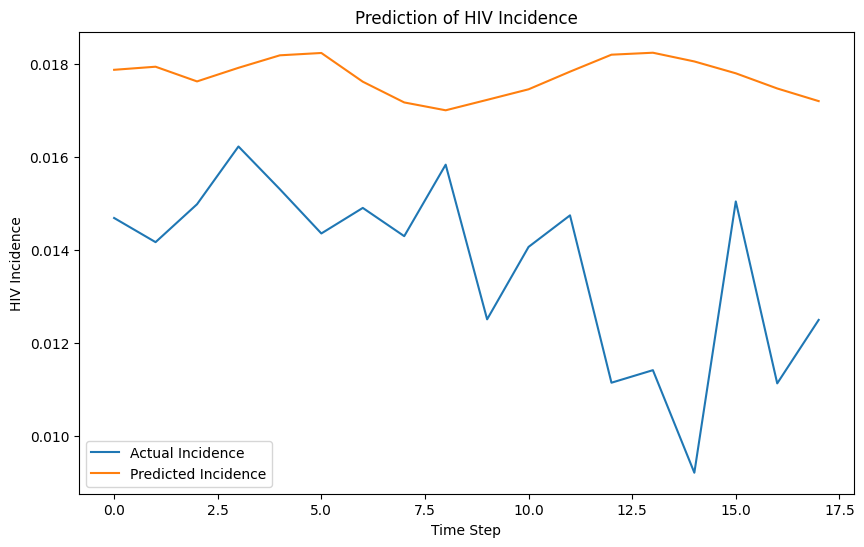

Predicted: [0.01787066 0.01793703 0.01762126 0.01791347 0.01818222 0.01823231
 0.01761511 0.01716935 0.01700061 0.01722485 0.01745174 0.0178311
 0.01819562 0.01823785 0.01805031 0.01779547 0.01746951 0.01719785]
Actual: [0.0146859  0.01416675 0.01498124 0.01622296 0.01530369 0.01435351
 0.01490254 0.01429542 0.01583203 0.01250794 0.01406447 0.01474263
 0.01114578 0.01141549 0.00921135 0.01504178 0.01113147 0.01249548]


In [ ]:
# 6. Evaluate and Visualize Predictions
# -----------------------------
# Make predictions on test data
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Evaluate LSTM model
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_lstm = mean_squared_error(y_test_inv, y_pred)
mae_lstm = mean_absolute_error(y_test_inv, y_pred)

if len(y_pred) == 0 or len(y_test_inv) == 0:
    print("Prediction or target is empty—cannot plot.")
elif np.isnan(y_pred).any() or np.isnan(y_test_inv).any():
    print("NaNs detected—check data scaling and formatting.")
else:
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label='Actual Incidence')
    plt.plot(y_pred, label='Predicted Incidence')
    plt.xlabel("Time Step")
    plt.ylabel("HIV Incidence")
    plt.title("Prediction of HIV Incidence")
    plt.legend()
    plt.show()

print("Predicted:", y_pred.ravel())
print("Actual:", y_test_inv.ravel())

In [ ]:
print("Predicted:", y_pred.ravel())
print("Actual:", y_test_inv.ravel())

Predicted: [0.01787066 0.01793703 0.01762126 0.01791347 0.01818222 0.01823231
 0.01761511 0.01716935 0.01700061 0.01722485 0.01745174 0.0178311
 0.01819562 0.01823785 0.01805031 0.01779547 0.01746951 0.01719785]
Actual: [0.0146859  0.01416675 0.01498124 0.01622296 0.01530369 0.01435351
 0.01490254 0.01429542 0.01583203 0.01250794 0.01406447 0.01474263
 0.01114578 0.01141549 0.00921135 0.01504178 0.01113147 0.01249548]


In [ ]:
#GRU

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# Define model architecture
model_gru = Sequential() # Renamed model to model_gru to avoid overwriting the LSTM model
model_gru.add(GRU(units=64, activation='tanh', return_sequences=False,
              input_shape=(X_train.shape[1], X_train.shape[2])))
model_gru.add(Dense(1))

# Compile the model
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Display the model summary
model_gru.summary()

# Train the model
history_gru = model_gru.fit(X_train, y_train, # Renamed history to history_gru
                    epochs=100,
                    batch_size=1,
                    validation_split=0.1,
                    verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, 64)             │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,121 (51.25 KB)

 Trainable params: 13,121 (51.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0718 - val_loss: 0.0616
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436 - val_loss: 0.0166
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0240 - val_loss: 0.0252
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313 - val_loss: 0.0025
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0368 - val_loss: 0.0030
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - val_loss: 0.0040
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.0053
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - val_loss: 0.0143
Epoch 9/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0300 - val_loss: 0.0011
Epoch 10/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0311 - val_loss: 0.0016
Epoch 11/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0243 - val_loss: 0.0134
Epoch 12/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

In [ ]:
#building sequence
grouped_sequences = {}

for band, group in df_with_totals.groupby('AgeBand'):
    # Select and scale input features
    features = group[['Tested_total', 'Positive_total']].values
    target = group['Incidence'].values.reshape(-1, 1)

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(features)
    y_scaled = scaler_y.fit_transform(target)

    # Build sequences
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback=3)

    # Save for later modeling
    grouped_sequences[band] = {
        'X': X_seq,
        'y': y_seq,
        'scaler_y': scaler_y,
        'scaler_X': scaler_X
    }

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Inverse transform predictions and actuals
y_pred_gru = scaler_y.inverse_transform(y_pred_scaled)  # GRU predictions
y_test_actual = scaler_y.inverse_transform(y_test)

# For LSTM, assume you have y_pred_lstm_scaled
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)

# Compute metrics
mse_gru = mean_squared_error(y_test_actual, y_pred_gru)
mae_gru = mean_absolute_error(y_test_actual, y_pred_gru)

mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_actual, y_pred_lstm)

print(f"GRU - MSE: {mse_gru:.4f}, MAE: {mae_gru:.4f}")
print(f"LSTM - MSE: {mse_lstm:.4f}, MAE: {mae_lstm:.4f}")

#building sequence
grouped_sequences = {}

for band, group in df_with_totals.groupby('AgeBand'):
    # Select and scale input features
    features = group[['Tested_total', 'Positive_total']].values
    target = group['Incidence'].values.reshape(-1, 1)

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_scaled = scaler_X.fit_transform(features)
    y_scaled = scaler_y.fit_transform(target)

    # Build sequences
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, lookback=3)

    # Save for later modeling
    grouped_sequences[band] = {
        'X': X_seq,
        'y': y_seq,
        'scaler_y': scaler_y,
        'scaler_X': scaler_X
    }

GRU - MSE: 0.0000, MAE: 0.0040
LSTM - MSE: 0.0000, MAE: 0.0040


In [ ]:
#plot prediction,GRU

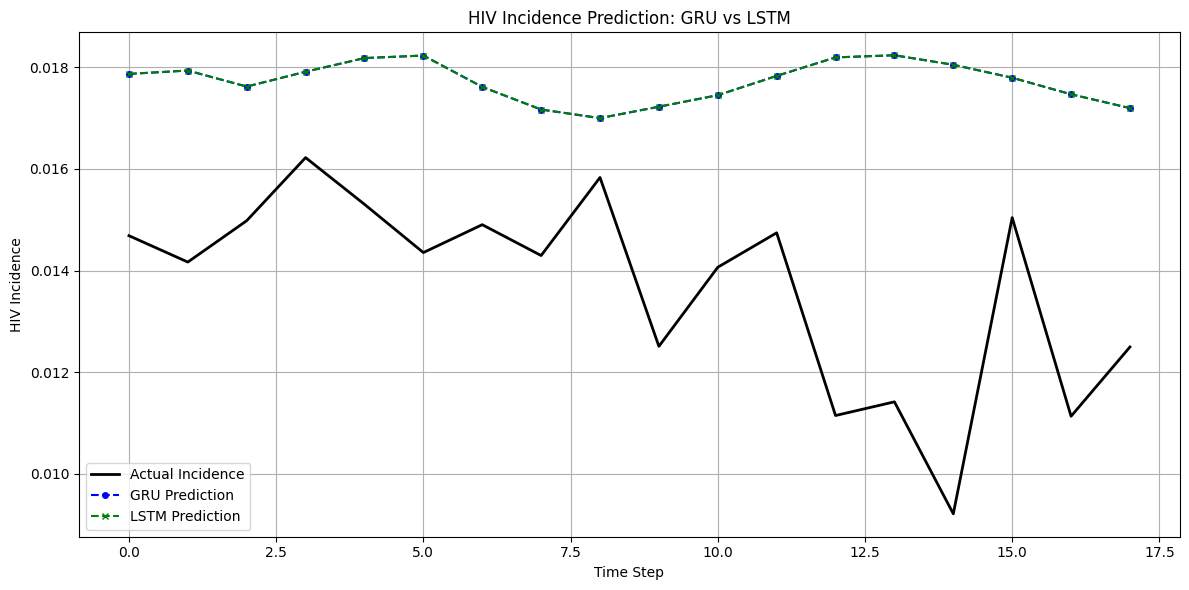

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Actual incidence
plt.plot(y_test_inv, label='Actual Incidence', color='black', linewidth=2)

# GRU predictions
plt.plot(y_pred_gru, label='GRU Prediction',
         color='blue', linestyle='--', marker='o', markersize=4)

# LSTM predictions
plt.plot(y_pred_lstm, label='LSTM Prediction',
         color='green', linestyle='--', marker='x', markersize=4)

# Formatting
plt.title("HIV Incidence Prediction: GRU vs LSTM")
plt.xlabel("Time Step")
plt.ylabel("HIV Incidence")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Input re-shape into 4D

In [ ]:
# Original shape: (samples, time_steps, features)
# Conv2D expects: (samples, height, width, channels)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [ ]:
#Conv2D Model for HIV Incidence Forecastin

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model_cnn = Sequential()
model_cnn.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=(lookback, X_train.shape[2], 1)))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1))

model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model_cnn.summary()

# Train the model
history_cnn = model_cnn.fit(X_train_cnn, y_train, epochs=100, batch_size=1, validation_split=0.1, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 2, 1, 32)       │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Predict and compare

In [ ]:
#add to comparison plot

In [ ]:
#RNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model_rnn.add(Dense(1))

model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.summary()

# Train the model
history_rnn = model_rnn.fit(X_train, y_train, epochs=100, batch_size=1, validation_split=0.1, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 64)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#RNN-predict and Evaluate

In [ ]:
# incidence analysis by Ethiopian Season
def assign_season(date):
    month = pd.to_datetime(date).month
    if month in [10, 11, 12, 1]:
        return 'Bega'
    elif month in [2, 3, 4, 5]:
        return 'Belg'
    elif month in [6, 7, 8, 9]:
        return 'Kiremt'
    else:
        return 'Unknown'


In [ ]:
df_with_totals['Season'] = df_with_totals['Gregorian_Date'].apply(assign_season)

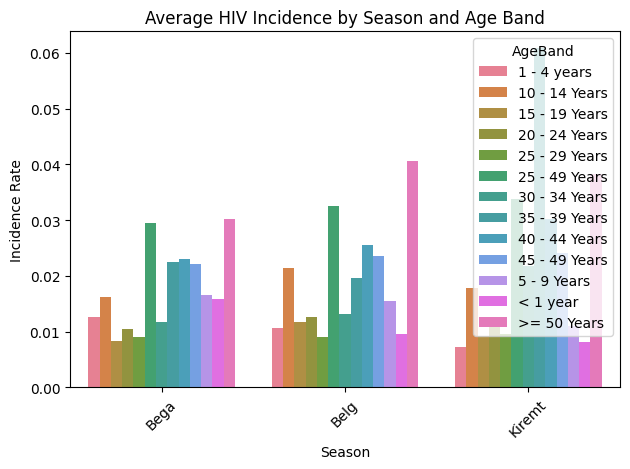

In [ ]:
#analyze and visualize
seasonal_summary = df_with_totals.groupby(['Season', 'AgeBand'])['Incidence'].mean().reset_index()
import seaborn as sns
sns.barplot(data=seasonal_summary, x='Season', y='Incidence', hue='AgeBand')
plt.title("Average HIV Incidence by Season and Age Band")
plt.ylabel("Incidence Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

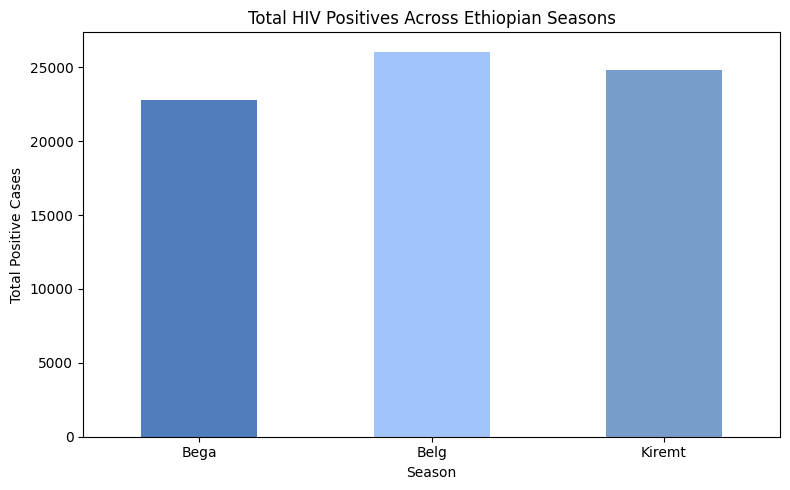

In [ ]:
#Total Positivity
def assign_season(date):
    month = pd.to_datetime(date).month
    if month in [10, 11, 12, 1]:
        return 'Bega'   # Dry
    elif month in [2, 3, 4, 5]:
        return 'Belg'   # Short rains
    elif month in [6, 7, 8, 9]:
        return 'Kiremt' # Long rains
    else:
        return 'Unknown'

df_with_totals['Season'] = df_with_totals['Gregorian_Date'].apply(assign_season)
#total positivity per season
positive_columns = [
    "Total_Positive_Clinics_PITC",
    "Total_Positive_Clinics_VCT",
    "Total_Positive_HealthCenters_PITC",
    "Total_Positive_HealthCenters_VCT",
    "Total_Positive_Hospitals_PITC",
    "Total_Positive_Hospitals_VCT"
]
#Aggregate
seasonal_totals = df_with_totals.groupby('Season')[positive_columns].sum()
seasonal_totals['Grand_Total_Positive'] = seasonal_totals.sum(axis=1)
#Visualize
seasonal_totals['Grand_Total_Positive'].plot(
    kind='bar',
    color=['#507dbc', '#a1c4fd', '#779ecb'],
    figsize=(8, 5),
    title='Total HIV Positives Across Ethiopian Seasons'
)
plt.ylabel("Total Positive Cases")
plt.xlabel("Season")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
#Forecasting and plotting pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def train_and_forecast(group_name, sequence_dict, epochs=100):
    X = sequence_dict['X']
    y = sequence_dict['y']
    scaler_y = sequence_dict['scaler_y']

    # Split into train/test
    train_size = int(len(X) * 0.8)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Model setup
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=1,
        validation_split=0.1,
        verbose=0
    )

    # Predict and inverse transform
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_test_inv = scaler_y.inverse_transform(y_test)

    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label='Actual Incidence')
    plt.plot(y_pred, label='Predicted Incidence')
    plt.xlabel("Time Step")
    plt.ylabel("HIV Incidence")
    plt.title(f"Forecast for AgeBand: {group_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model

# **##Age-band wise prediction-Trials **

🔮 Forecasting for AgeBand: 1 - 4 years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


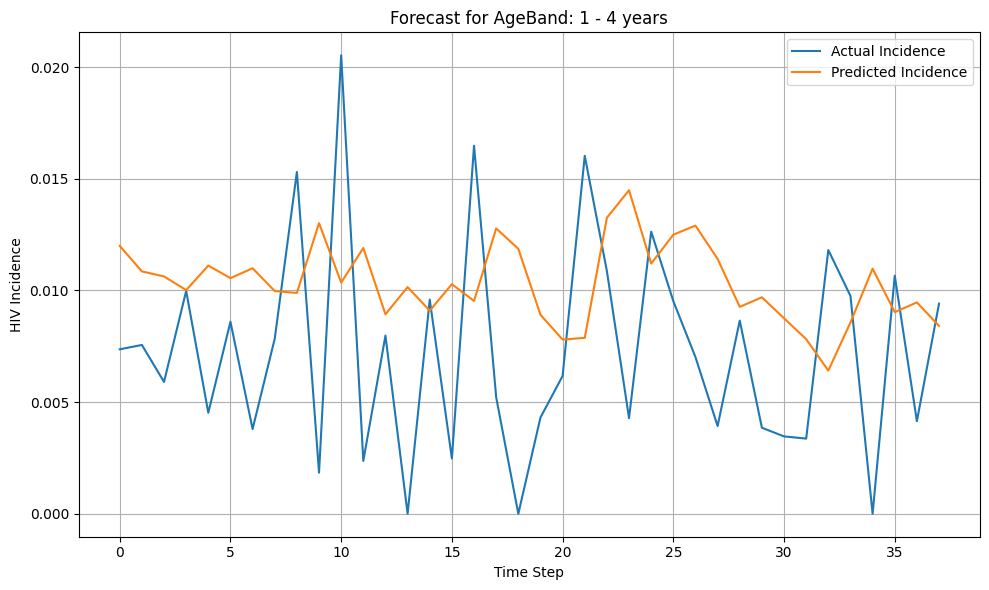

🔮 Forecasting for AgeBand: 10 - 14 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


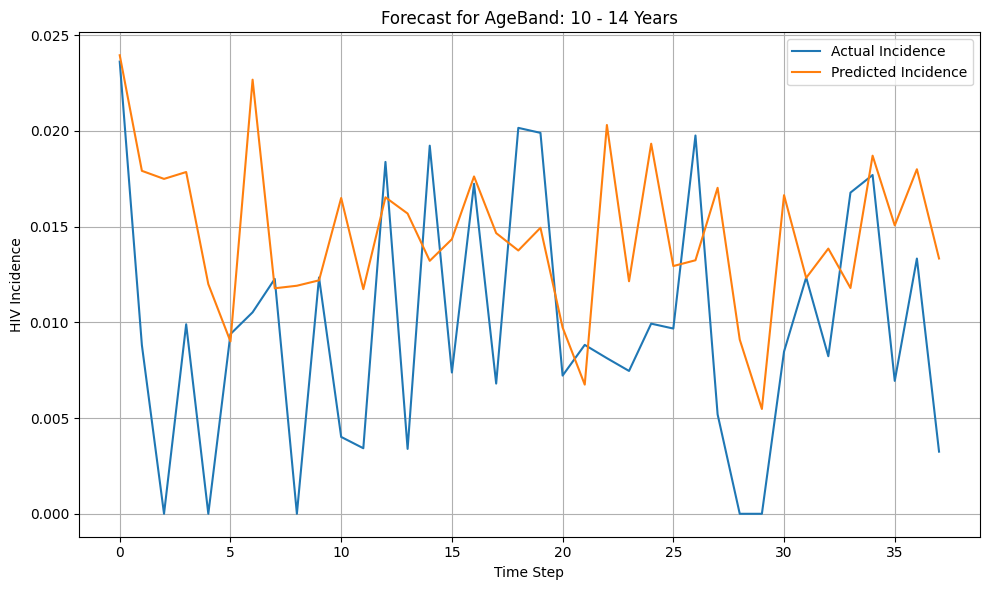

🔮 Forecasting for AgeBand: 15 - 19 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


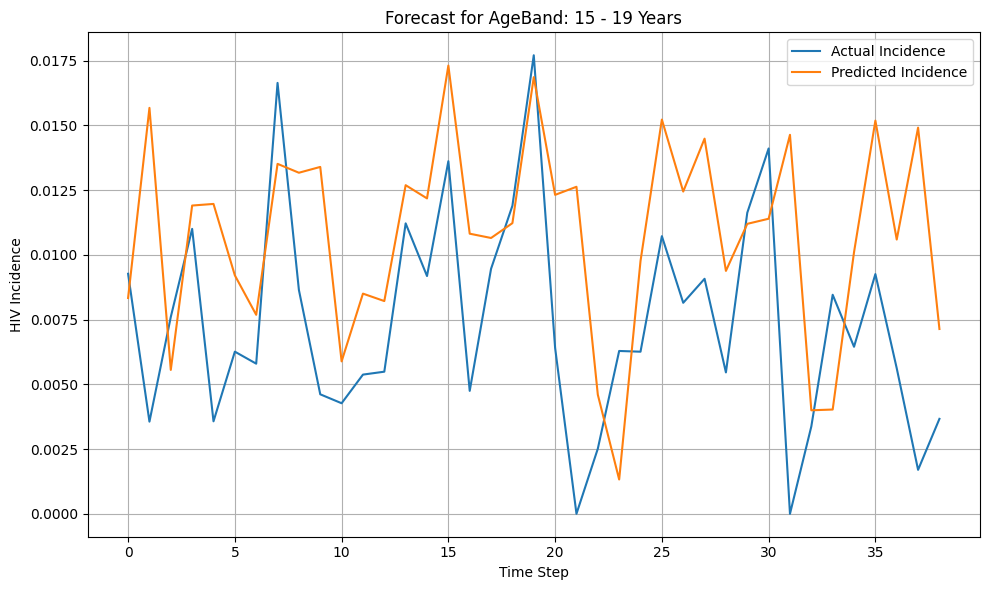

🔮 Forecasting for AgeBand: 20 - 24 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


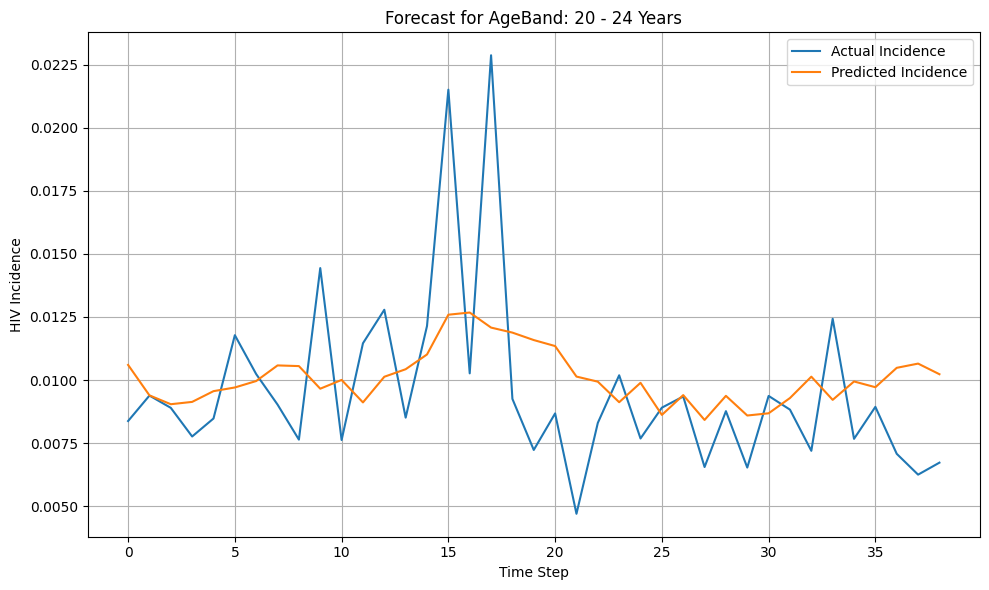

🔮 Forecasting for AgeBand: 25 - 29 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


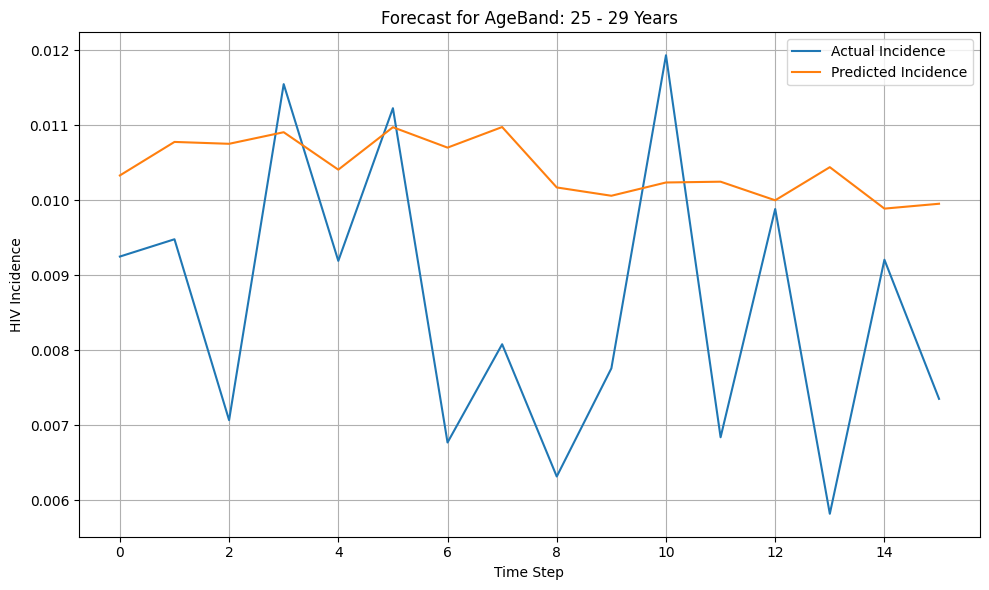

🔮 Forecasting for AgeBand: 25 - 49 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


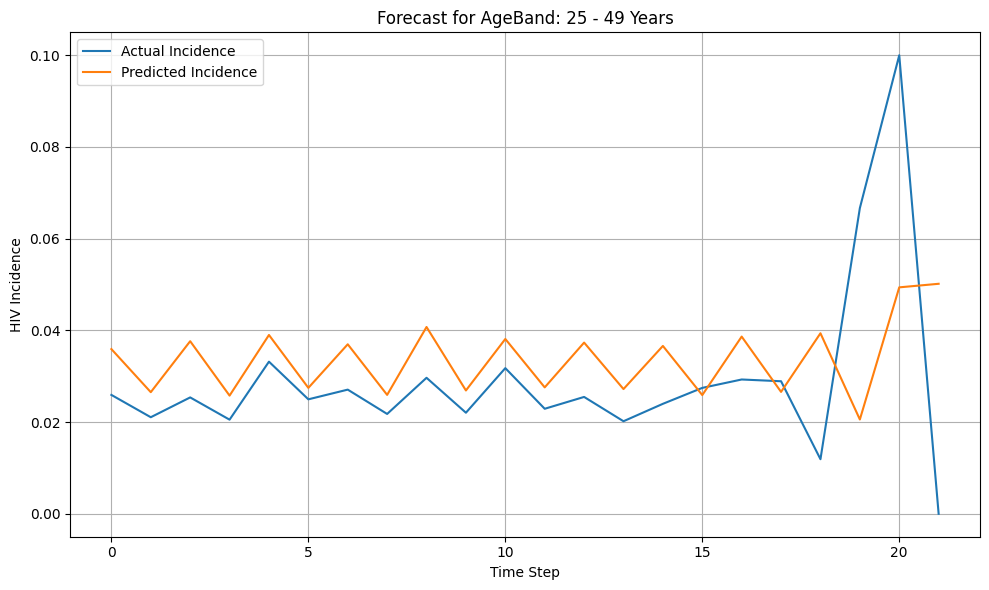

🔮 Forecasting for AgeBand: 30 - 34 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


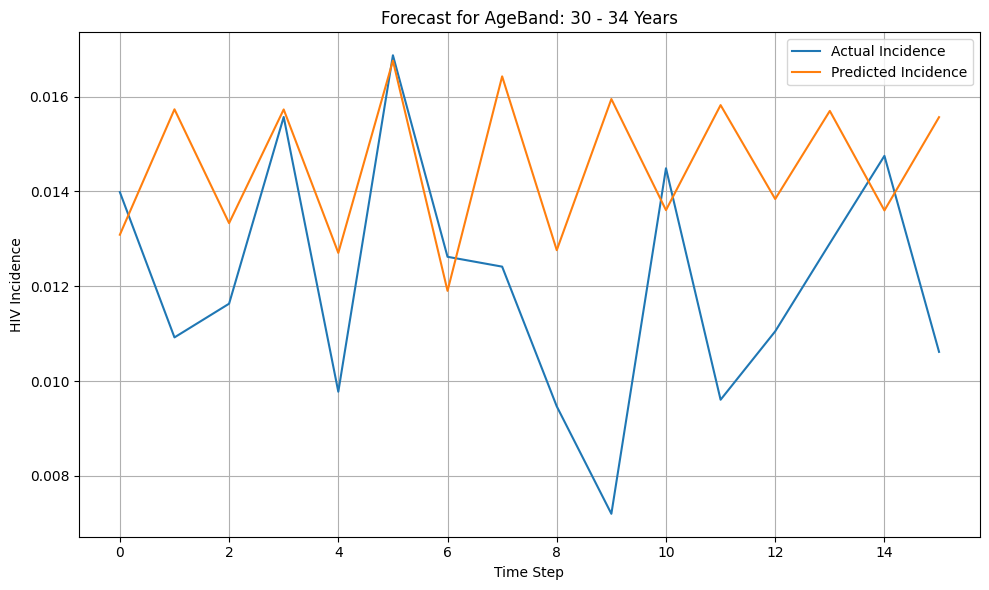

🔮 Forecasting for AgeBand: 35 - 39 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


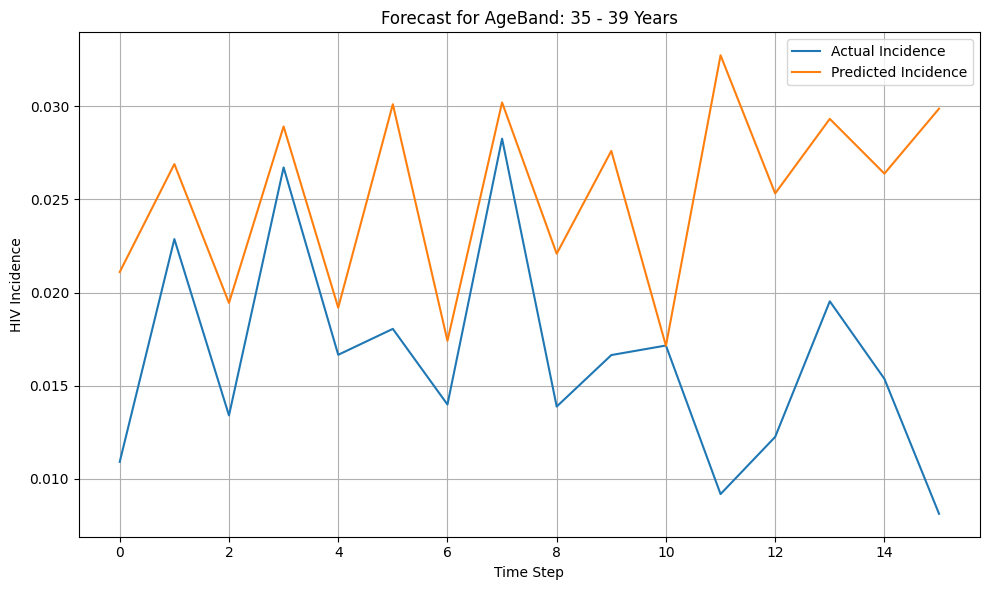

🔮 Forecasting for AgeBand: 40 - 44 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


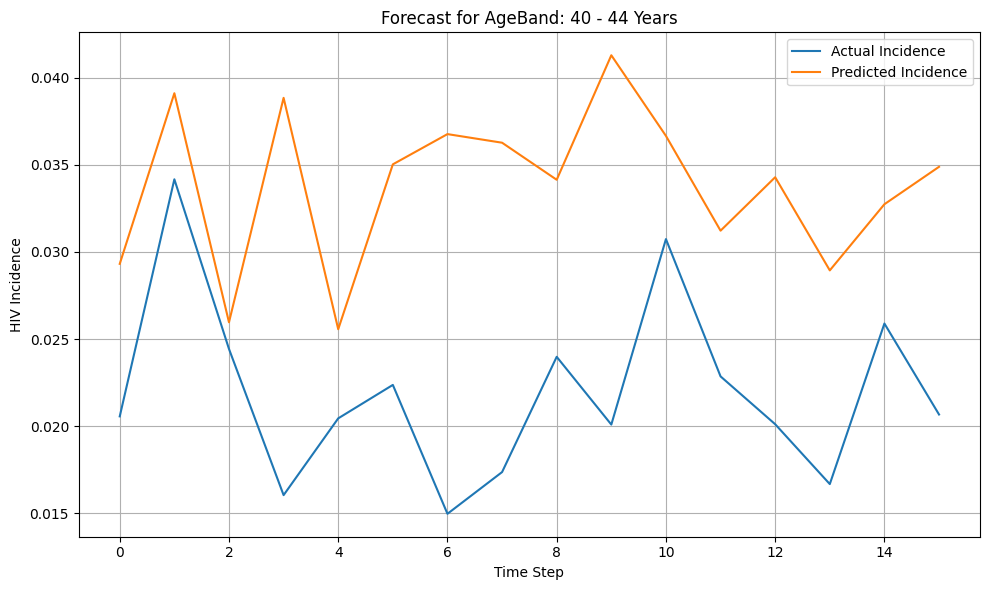

🔮 Forecasting for AgeBand: 45 - 49 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


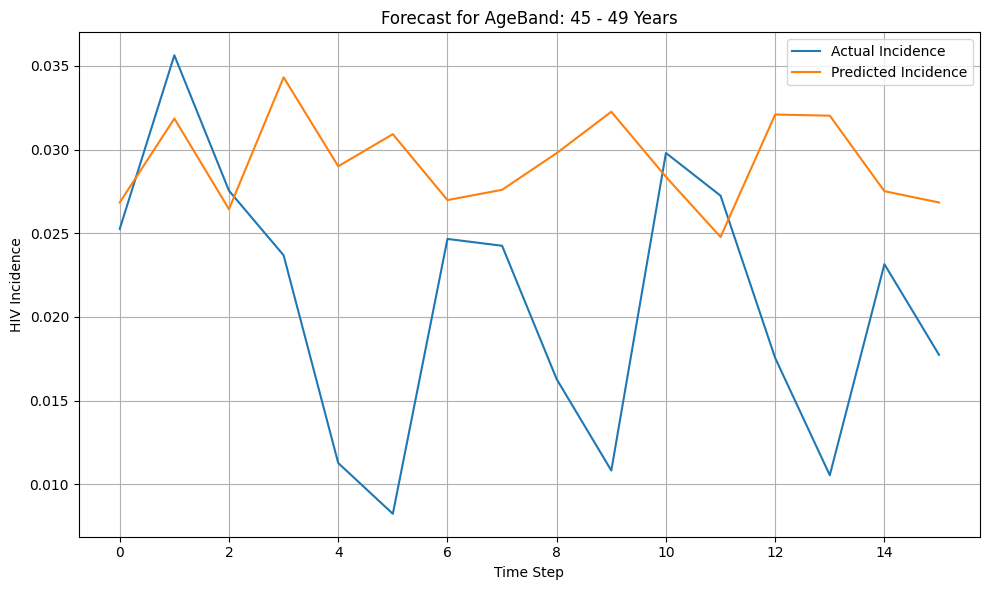

🔮 Forecasting for AgeBand: 5 - 9 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


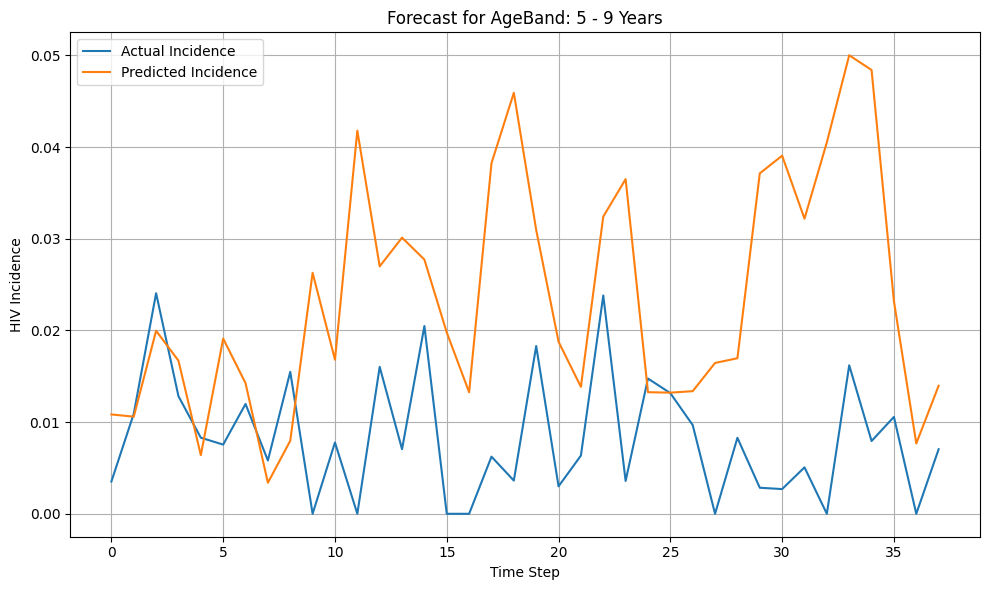

🔮 Forecasting for AgeBand: < 1 year


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


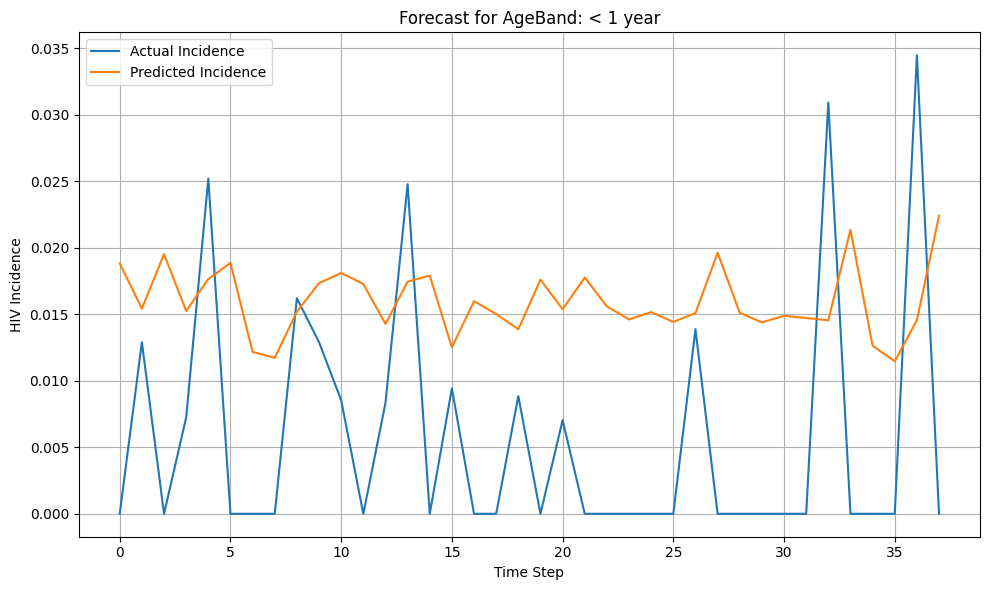

🔮 Forecasting for AgeBand: >= 50 Years


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


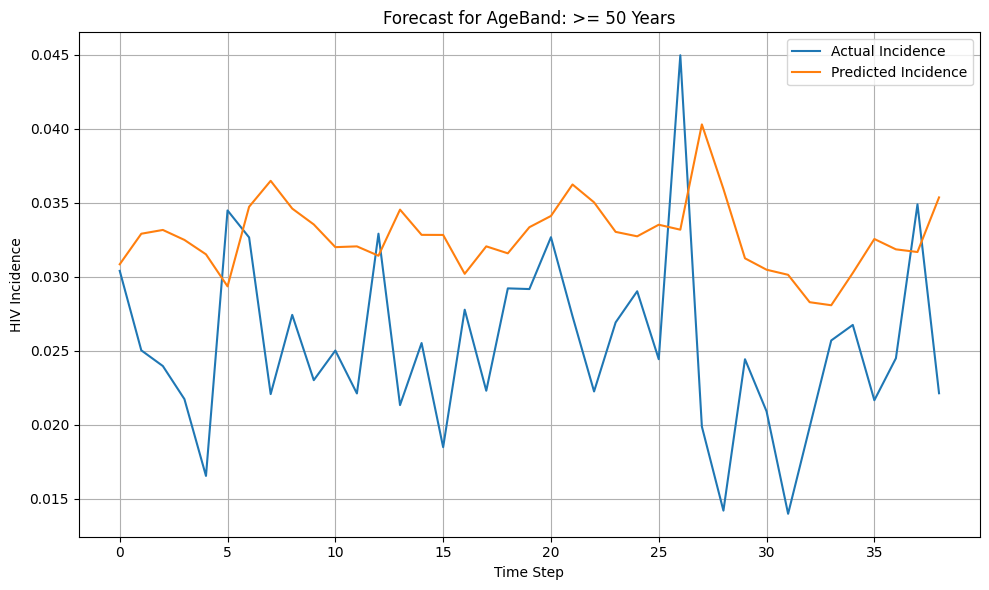

In [ ]:
models = {}
for band, seq_data in grouped_sequences.items():
    print(f"🔮 Forecasting for AgeBand: {band}")
    model = train_and_forecast(band, seq_data, epochs=60)
    models[band] = model

*#Summary of steps I followed *

*Data Loading and Initial Processing
*Feture Enginering
*Data Loading and pre-processing
*Data preparation for time-series models
*Model Development and Experimentation
*Model Evaluation and Comparison
  

Furter expermentations are recommended : window size , stride, epoch modificatio